In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

In [2]:
# sim / halo info
base_dir = '/scratch/ksf293/equivariant-cosmology/data'
snap_num_str = '099' # z = 0
sim_name = 'TNG100-1'
sim_name_dark = 'TNG100-1-Dark'
# sim_name = 'TNG50-4'
# sim_name_dark = 'TNG50-4-Dark'
halo_dir = f'../data/halos/halos_{sim_name}'
halo_tag = '_nstarpartmin1_twin'
fn_dark_halo_arr = f'{halo_dir}/halos_{sim_name}{halo_tag}.npy'
mass_multiplier = 1e10
log_mass_shift = 10

In [3]:
# geo info
geo_dir = f'../data/geometric_features/geometric_features_{sim_name}'
geo_tag = '_xminPEsub_rall'
fn_geo_features = f'{geo_dir}/geometric_features{halo_tag}{geo_tag}.npy'
print(fn_geo_features)

../data/geometric_features/geometric_features_TNG100-1/geometric_features_nstarpartmin1_twin_xminPEsub_rall.npy


In [4]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(fn_geo_features)

In [5]:
n_groups = [[0,1,2], [3,4,5,6,7], [8,9,10]]
geo_feature_arr_rebinned = utils.rebin_geometric_features(geo_featurizer.geo_feature_arr, n_groups)
geo_feature_arr_pseudo = utils.transform_pseudotensors(geo_feature_arr_rebinned)

In [6]:
sim_reader = SimulationReader(base_dir, sim_name, sim_name_dark, snap_num_str)
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()
sim_reader.add_catalog_property_to_halos('mass_hydro_subhalo_star')
sim_reader.add_catalog_property_to_halos('m200m')

In [7]:
sim_reader.add_catalog_property_to_halos('r200m')
sim_reader.add_catalog_property_to_halos('v200m')

In [8]:
m_stellar = np.array([dark_halo.catalog_properties['mass_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_stellar = np.log10(m_stellar)
log_m_200m = np.log10(m_200m)
N_halos = len(sim_reader.dark_halo_arr)
print('N_halos:', N_halos)

N_halos: 20098


In [9]:
r_200m = np.array([dark_halo.catalog_properties['r200m'] for dark_halo in sim_reader.dark_halo_arr])
v_200m = np.array([dark_halo.catalog_properties['v200m'] for dark_halo in sim_reader.dark_halo_arr])

Text(0, 0.5, 'count')

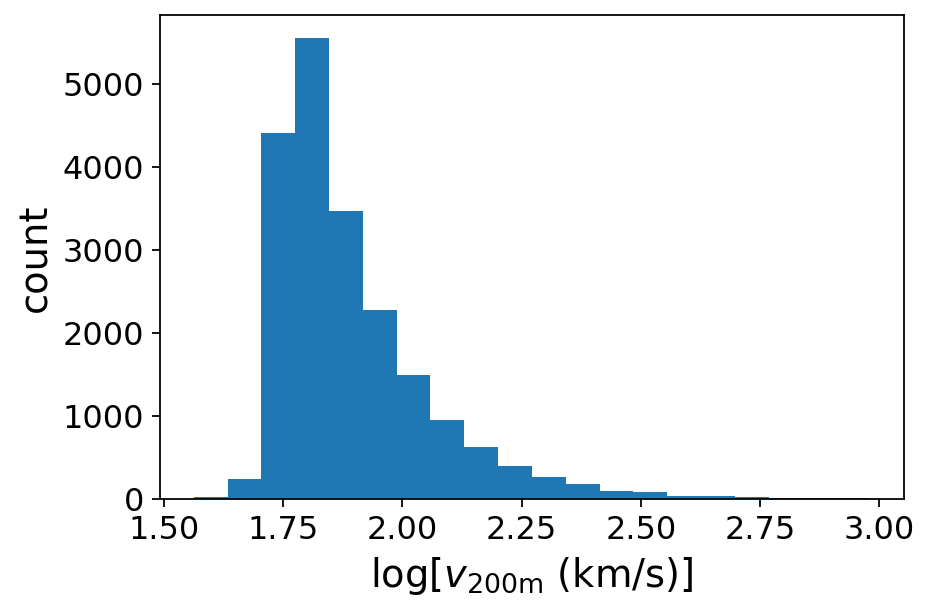

In [10]:
plt.hist(np.log10(v_200m), bins=20)
plt.xlabel(r'$\mathrm{log}[v_{200\mathrm{m}}$ (km/s)]')
plt.ylabel('count')

Text(0, 0.5, '$R_{200m}$ ($h^{-1} \\,$ ckpc)')

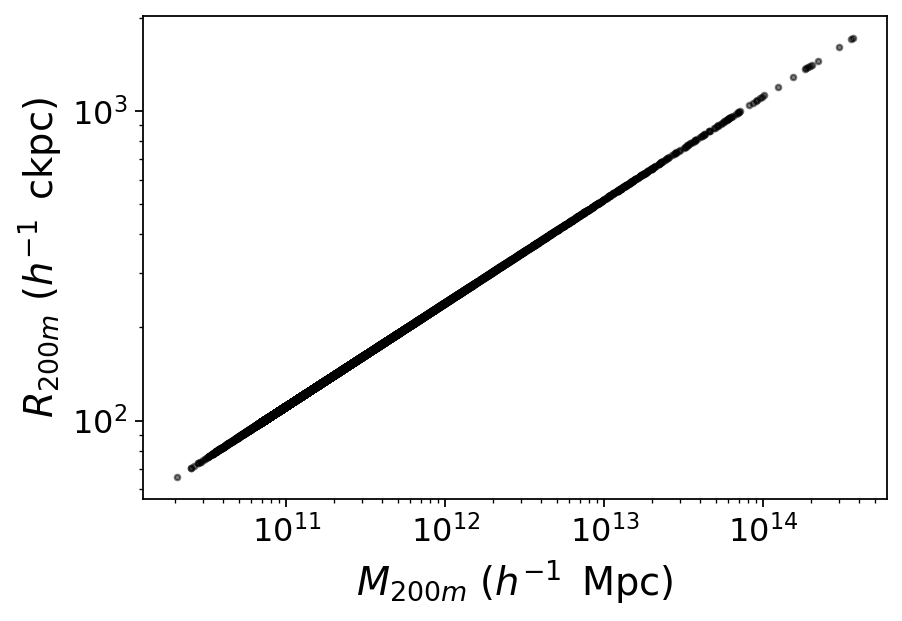

In [11]:
plt.scatter(m_200m*mass_multiplier, r_200m, c='k', s=6, alpha=0.5)
plt.loglog()
plt.xlabel(r'$M_{200m}$ ($h^{-1} \,$ Mpc)')
plt.ylabel(r'$R_{200m}$ ($h^{-1} \,$ ckpc)')

Text(0, 0.5, '$V_{200m}$ (km/s)')

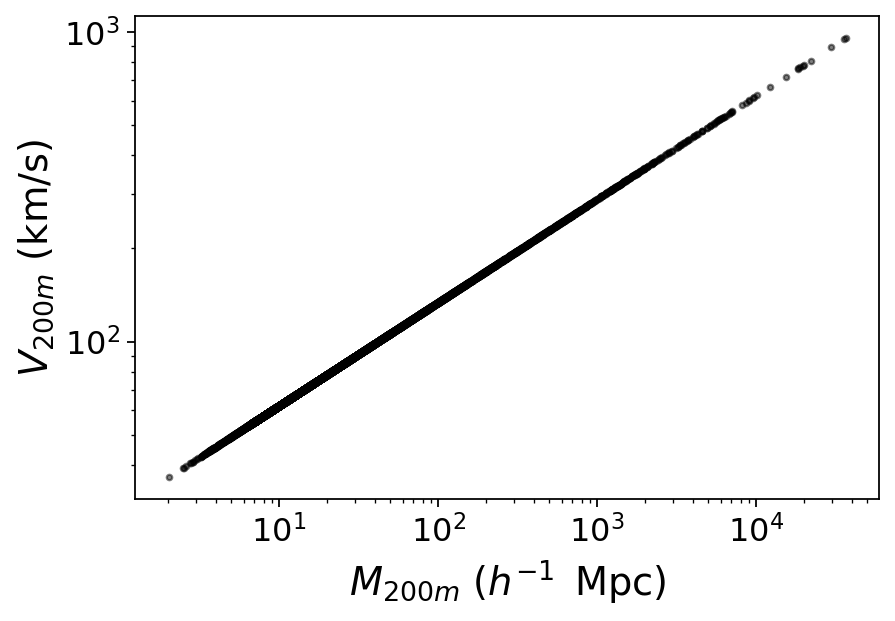

In [12]:
plt.scatter(m_200m, v_200m, c='k', s=6, alpha=0.5)
plt.loglog()
plt.xlabel(r'$M_{200m}$ ($h^{-1} \,$ Mpc)')
plt.ylabel(r'$V_{200m}$ (km/s)')

## Set up general scalar featurizer

In [13]:
# scalar info
scalar_featurizer = ScalarFeaturizer(geo_feature_arr_pseudo)
scalar_featurizer.rescale_geometric_features(m_200m, r_200m, v_200m)

# m_dm is in units of 1/1e10, this M_tot value is already in the units we're using internally (log(M/1e10))
x_features_extra = np.vstack((m_200m, r_200m, v_200m)).T
x_features_extra = np.log10(x_features_extra)   

## Split train-val-test

In [14]:
frac_train = 0.70
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, frac_test=frac_test)

print(len(idx_train), len(idx_test), len(idx_val))

14068 3015 3015


## Uncertainties & powerlaw

In [15]:
uncertainties_genel2019 = utils.get_uncertainties_genel2019(log_m_stellar+log_mass_shift, sim_name=sim_name)

In [16]:
log_m_200m_train = log_m_200m[idx_train]
log_m_stellar_train = log_m_stellar[idx_train]
uncertainties_genel2019_train = uncertainties_genel2019[idx_train]
y_val_current_powerlaw_fit_train, params_best_fit, params_initial_guess = utils.fit_broken_power_law(
                                                        log_m_200m_train, log_m_stellar_train, 
                                                        uncertainties=uncertainties_genel2019_train, 
                                                        return_initial_guess=True)
y_val_current_powerlaw_fit = utils.broken_power_law(log_m_200m, *params_best_fit)

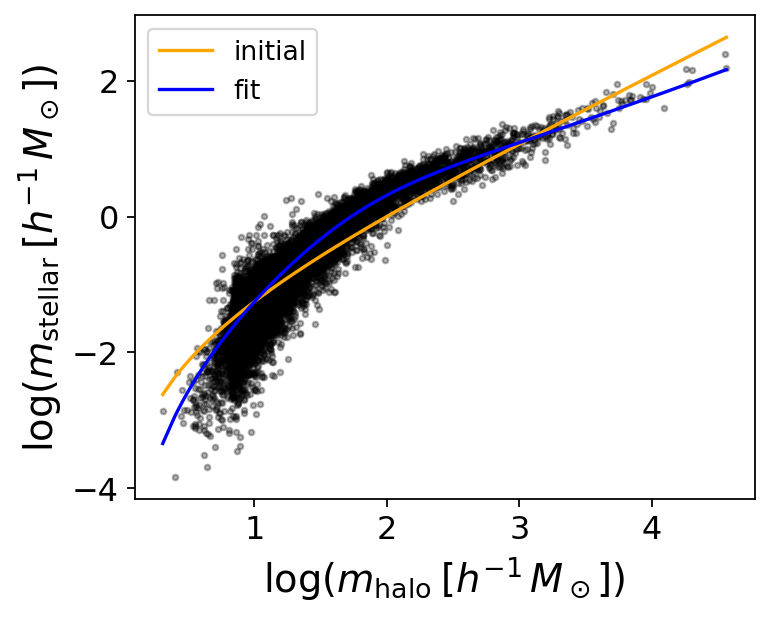

In [17]:
plt.figure(figsize=(5,4))
# sort for plotting niceness
idx_m_200m = np.argsort(log_m_200m_train)
y_initial_train = utils.broken_power_law(log_m_200m_train, *params_initial_guess)
plt.scatter(log_m_200m_train[idx_m_200m], log_m_stellar_train[idx_m_200m], s=6, c='k', alpha=0.3)
plt.plot(log_m_200m_train[idx_m_200m], y_initial_train[idx_m_200m], color='orange', label='initial')
plt.plot(log_m_200m_train[idx_m_200m], y_val_current_powerlaw_fit_train[idx_m_200m], color='blue', label='fit')
plt.xlabel(utils.label_dict['m200m'])
plt.ylabel(utils.label_dict['mstellar'])
plt.legend(fontsize=12)

## Baseline

0.25233400290871244


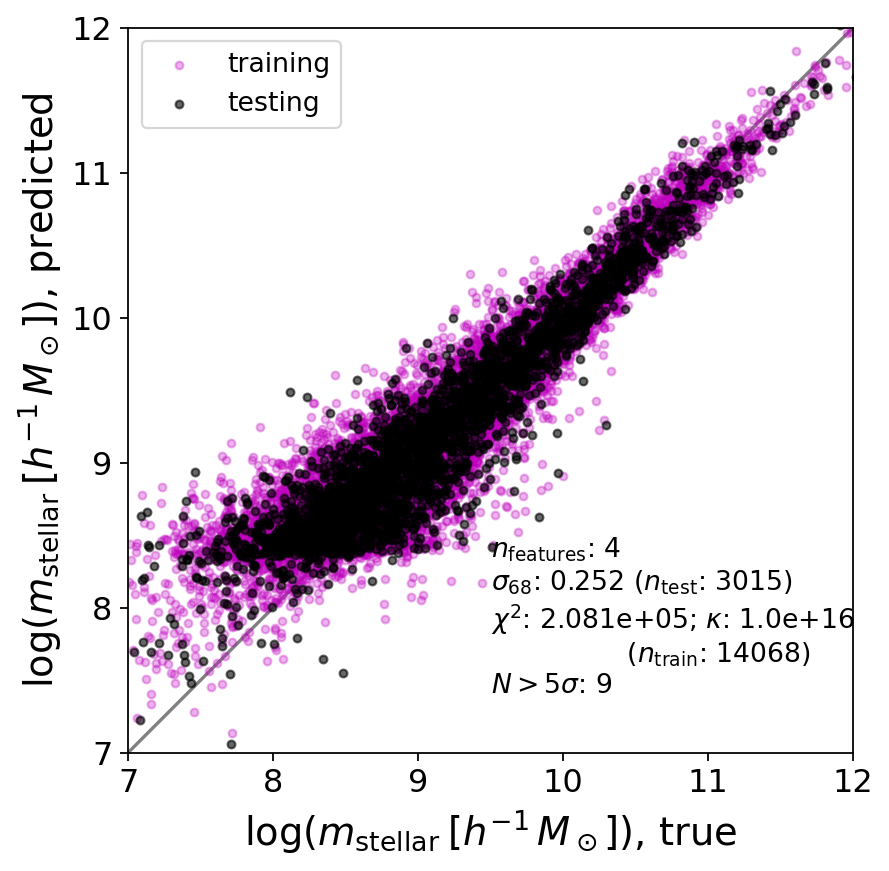

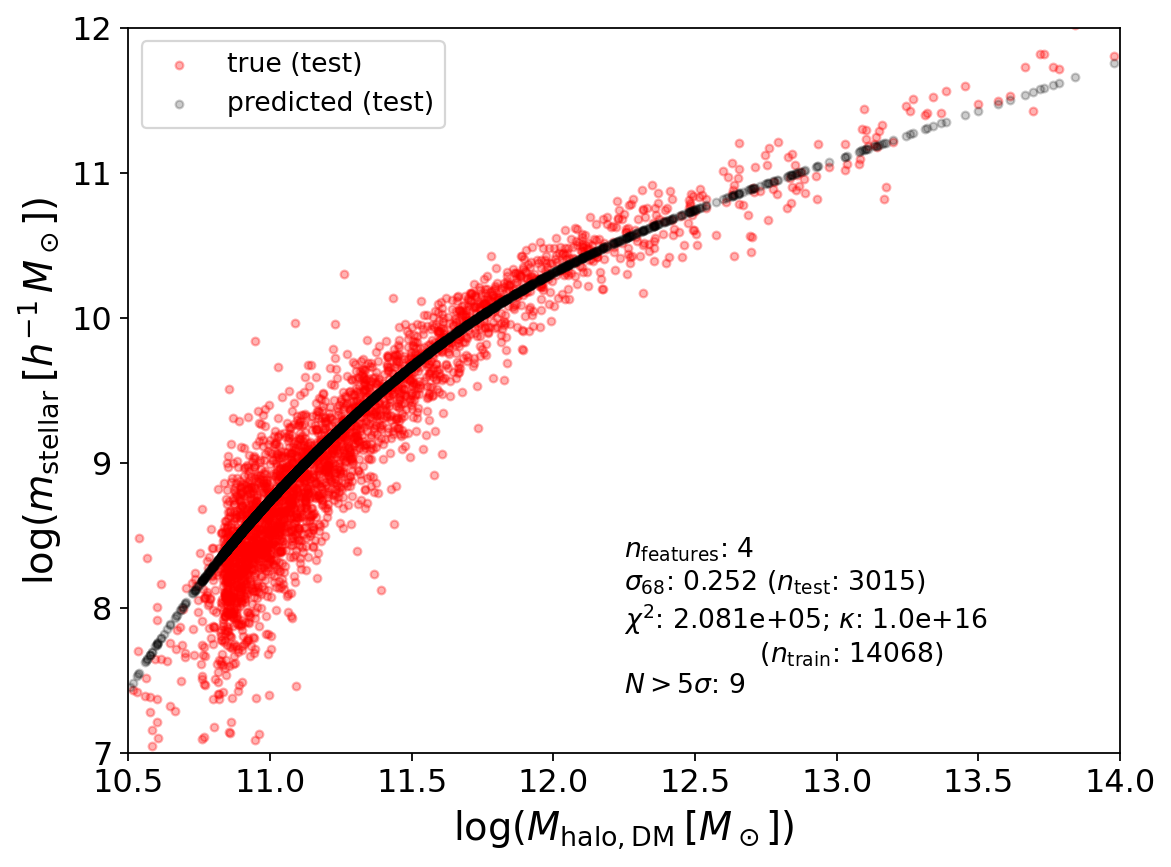

In [18]:
ones_features = np.atleast_2d(np.ones(len(log_m_stellar))).T
x_extra_mtot = np.atleast_2d(np.log10(m_200m)).T
fitter = LinearFitter(ones_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_extra_mtot)
fitter.split_train_test(idx_train, idx_val)
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
plotter.plot_fits(fitter, log_m_200m, log_mass_shift=log_mass_shift)
error_powerlawM, _ = utils.compute_error(fitter, test_error_type='percentile')
print(error_powerlawM)

0.2525814660303075


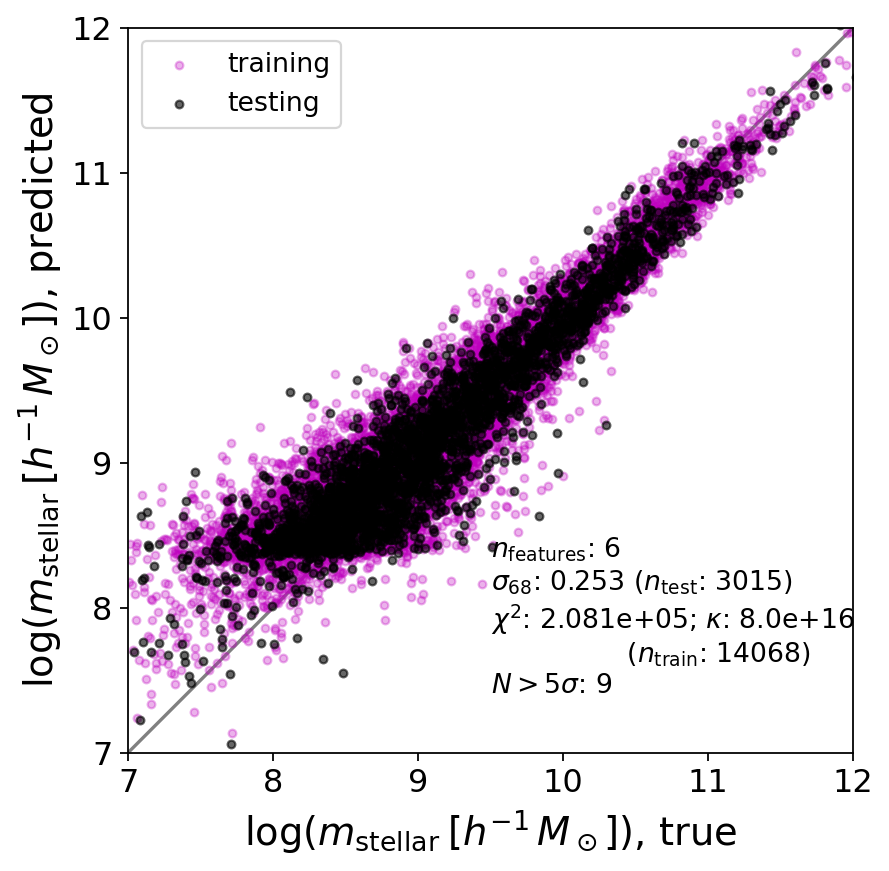

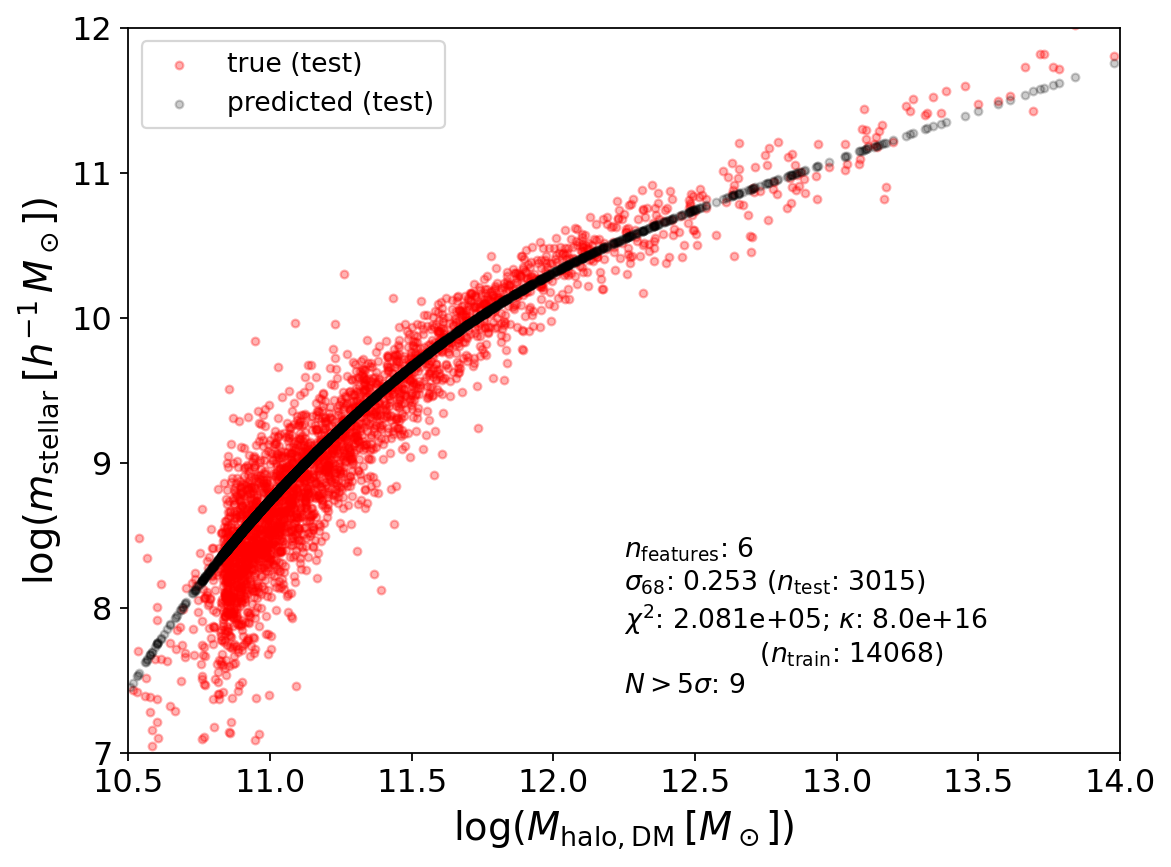

In [19]:
ones_features = np.atleast_2d(np.ones(len(log_m_stellar))).T
#x_extra_mtot = np.atleast_2d(np.log10(m_200m)).T
fitter = LinearFitter(ones_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test(idx_train, idx_val)
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
plotter.plot_fits(fitter, log_m_200m, log_mass_shift=log_mass_shift)
error_powerlawMRV, _ = utils.compute_error(fitter, test_error_type='percentile')
print(error_powerlawMRV)

## Full scalar featurizer

In [20]:
from IPython.display import display, Markdown

In [21]:
m_order_max = 2
x_order_max = 4
v_order_max = 4
scalar_tag = f'_3bins_pseudo_rescaled_mord{m_order_max}_xord{x_order_max}_vord{v_order_max}'
scalar_dir = f'../data/scalar_features/scalar_features_{sim_name}'
fn_scalar_features = f'{scalar_dir}/scalar_features{halo_tag}{geo_tag}{scalar_tag}.npy'

print('loading')
scalar_featurizer.load_features(fn_scalar_features)
print('loaded')
s_feats = [s for s in scalar_featurizer.scalar_feature_arr[0]]
for s in s_feats:
    display(Markdown(scalar_name(s, geo_feature_arr_pseudo)))

loading
loaded


$m_0$

$m_1$

$m_2$

$\lambda_3(C^{vv}_0)$

$\lambda_1(C^{vv}_0)$

$\lambda_2(C^{vv}_0)$

$\lambda_3(C^{vv}_1)$

$\lambda_2(C^{vv}_1)$

$\lambda_1(C^{vv}_1)$

$\lambda_1(C^{vv}_2)$

$\lambda_2(C^{vv}_2)$

$\lambda_3(C^{vv}_2)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(C^{xx}_0)$

$\lambda_3(C^{xx}_0)$

$\lambda_1(C^{xx}_0)$

$\lambda_3(C^{xx}_1)$

$\lambda_2(C^{xx}_1)$

$\lambda_1(C^{xx}_1)$

$\lambda_2(C^{xx}_2)$

$\lambda_1(C^{xx}_2)$

$\lambda_3(C^{xx}_2)$

$m_0 \, m_0$

$m_0 \, m_1$

$m_0 \, m_2$

$m_1 \, m_1$

$m_1 \, m_2$

$m_2 \, m_2$

$m_0 \, \lambda_1(C^{vv}_0)$

$m_0 \, \lambda_2(C^{vv}_0)$

$m_0 \, \lambda_3(C^{vv}_0)$

$[v_0]_{j} \, [v_0]_{j}$

$\lambda_1(C^{vv}_0) \, m_1$

$\lambda_3(C^{vv}_0) \, m_1$

$m_0 \, \lambda_3(C^{vv}_1)$

$m_0 \, \lambda_2(C^{vv}_1)$

$\lambda_2(C^{vv}_0) \, m_1$

$[v_0]_{j} \, [v_1]_{j}$

$m_0 \, \lambda_1(C^{vv}_1)$

$[v_0]_{j} \, [v_2]_{j}$

$m_0 \, \lambda_2(C^{vv}_2)$

$\lambda_3(C^{vv}_0) \, m_2$

$m_0 \, \lambda_3(C^{vv}_2)$

$\lambda_1(C^{vv}_0) \, m_2$

$\lambda_2(C^{vv}_0) \, m_2$

$m_0 \, \lambda_1(C^{vv}_2)$

$[v_1]_{j} \, [v_1]_{j}$

$m_1 \, \lambda_1(C^{vv}_1)$

$m_1 \, \lambda_2(C^{vv}_1)$

$m_1 \, \lambda_3(C^{vv}_1)$

$[v_1]_{j} \, [v_2]_{j}$

$m_1 \, \lambda_3(C^{vv}_2)$

$m_1 \, \lambda_2(C^{vv}_2)$

$m_1 \, \lambda_1(C^{vv}_2)$

$\lambda_3(C^{vv}_1) \, m_2$

$\lambda_2(C^{vv}_1) \, m_2$

$\lambda_1(C^{vv}_1) \, m_2$

$[v_2]_{j} \, [v_2]_{j}$

$m_2 \, \lambda_3(C^{vv}_2)$

$m_2 \, \lambda_2(C^{vv}_2)$

$m_2 \, \lambda_1(C^{vv}_2)$

$\lambda_2(C^{vv}_0) \, \lambda_2(C^{vv}_0)$

$\lambda_2(C^{vv}_0) \, \lambda_1(C^{vv}_0)$

$\lambda_1(C^{vv}_0) \, \lambda_1(C^{vv}_0)$

$\lambda_3(C^{vv}_0) \, \lambda_3(C^{vv}_0)$

$\lambda_3(C^{vv}_0) \, \lambda_2(C^{vv}_0)$

$\lambda_3(C^{vv}_0) \, \lambda_1(C^{vv}_0)$

$[C^{vv}_0]_{jk} \, [C^{vv}_0]_{jk}$

$\lambda_1(C^{vv}_0) \, \lambda_1(C^{vv}_1)$

$\lambda_3(C^{vv}_0) \, \lambda_3(C^{vv}_1)$

$\lambda_3(C^{vv}_0) \, \lambda_2(C^{vv}_1)$

$\lambda_3(C^{vv}_0) \, \lambda_1(C^{vv}_1)$

$\lambda_1(C^{vv}_0) \, \lambda_2(C^{vv}_1)$

$\lambda_2(C^{vv}_0) \, \lambda_3(C^{vv}_1)$

$[C^{vv}_0]_{jk} \, [C^{vv}_1]_{jk}$

$\lambda_2(C^{vv}_0) \, \lambda_1(C^{vv}_1)$

$\lambda_1(C^{vv}_0) \, \lambda_3(C^{vv}_1)$

$\lambda_2(C^{vv}_0) \, \lambda_2(C^{vv}_1)$

$\lambda_2(C^{vv}_0) \, \lambda_3(C^{vv}_2)$

$\lambda_3(C^{vv}_0) \, \lambda_1(C^{vv}_2)$

$\lambda_3(C^{vv}_0) \, \lambda_2(C^{vv}_2)$

$\lambda_1(C^{vv}_0) \, \lambda_2(C^{vv}_2)$

$\lambda_1(C^{vv}_0) \, \lambda_1(C^{vv}_2)$

$\lambda_2(C^{vv}_0) \, \lambda_2(C^{vv}_2)$

$\lambda_2(C^{vv}_0) \, \lambda_1(C^{vv}_2)$

$[C^{vv}_0]_{jk} \, [C^{vv}_2]_{jk}$

$\lambda_1(C^{vv}_0) \, \lambda_3(C^{vv}_2)$

$\lambda_3(C^{vv}_0) \, \lambda_3(C^{vv}_2)$

$\lambda_3(C^{vv}_1) \, \lambda_1(C^{vv}_1)$

$[C^{vv}_1]_{jk} \, [C^{vv}_1]_{jk}$

$\lambda_2(C^{vv}_1) \, \lambda_2(C^{vv}_1)$

$\lambda_2(C^{vv}_1) \, \lambda_1(C^{vv}_1)$

$\lambda_3(C^{vv}_1) \, \lambda_3(C^{vv}_1)$

$\lambda_3(C^{vv}_1) \, \lambda_2(C^{vv}_1)$

$\lambda_1(C^{vv}_1) \, \lambda_1(C^{vv}_1)$

$\lambda_2(C^{vv}_1) \, \lambda_2(C^{vv}_2)$

$\lambda_2(C^{vv}_1) \, \lambda_3(C^{vv}_2)$

$\lambda_3(C^{vv}_1) \, \lambda_2(C^{vv}_2)$

$\lambda_2(C^{vv}_1) \, \lambda_1(C^{vv}_2)$

$\lambda_3(C^{vv}_1) \, \lambda_1(C^{vv}_2)$

$\lambda_3(C^{vv}_1) \, \lambda_3(C^{vv}_2)$

$\lambda_1(C^{vv}_1) \, \lambda_1(C^{vv}_2)$

$\lambda_1(C^{vv}_1) \, \lambda_2(C^{vv}_2)$

$\lambda_1(C^{vv}_1) \, \lambda_3(C^{vv}_2)$

$[C^{vv}_1]_{jk} \, [C^{vv}_2]_{jk}$

$\lambda_2(C^{vv}_2) \, \lambda_2(C^{vv}_2)$

$\lambda_3(C^{vv}_2) \, \lambda_2(C^{vv}_2)$

$\lambda_3(C^{vv}_2) \, \lambda_3(C^{vv}_2)$

$\lambda_3(C^{vv}_2) \, \lambda_1(C^{vv}_2)$

$\lambda_1(C^{vv}_2) \, \lambda_1(C^{vv}_2)$

$[C^{vv}_2]_{jk} \, [C^{vv}_2]_{jk}$

$\lambda_2(C^{vv}_2) \, \lambda_1(C^{vv}_2)$

$m_0 \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$[v_0]_{j} \, [x_0]_{j}$

$m_0 \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$m_0 \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$m_0 \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$m_0 \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, m_1$

$m_0 \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, m_1$

$[x_0]_{j} \, [v_1]_{j}$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, m_1$

$[v_0]_{j} \, [x_1]_{j}$

$[v_0]_{j} \, [x_2]_{j}$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, m_2$

$m_0 \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$m_0 \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$m_0 \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$[x_0]_{j} \, [v_2]_{j}$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, m_2$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, m_2$

$m_1 \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$[v_1]_{j} \, [x_1]_{j}$

$m_1 \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$m_1 \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$[v_1]_{j} \, [x_2]_{j}$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, m_2$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, m_2$

$[x_1]_{j} \, [v_2]_{j}$

$m_1 \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, m_2$

$m_1 \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$m_1 \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$m_2 \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$[v_2]_{j} \, [x_2]_{j}$

$m_2 \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$m_2 \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$[C^{vv}_0]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk}$

$\lambda_1(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_1(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_1(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_2(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_3(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_3(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_2(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_2(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_3(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_1(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_1(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{vv}_1)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{vv}_1)$

$\lambda_3(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_2(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{vv}_1)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{vv}_1)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{vv}_1)$

$[C^{vv}_0]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk}$

$[\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk} \, [C^{vv}_1]_{jk}$

$\lambda_1(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_3(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{vv}_1)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{vv}_1)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{vv}_1)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{vv}_1)$

$\lambda_2(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_2(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_3(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{vv}_2)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{vv}_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{vv}_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{vv}_2)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{vv}_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{vv}_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{vv}_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{vv}_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{vv}_2)$

$\lambda_3(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_3(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_3(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$[\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk} \, [C^{vv}_2]_{jk}$

$\lambda_1(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_1(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_1(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$[C^{vv}_0]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk}$

$\lambda_3(C^{vv}_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_3(C^{vv}_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_3(C^{vv}_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_1(C^{vv}_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_2(C^{vv}_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_1(C^{vv}_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_1(C^{vv}_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$[C^{vv}_1]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk}$

$\lambda_2(C^{vv}_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_2(C^{vv}_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(C^{vv}_2)$

$[\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk} \, [C^{vv}_2]_{jk}$

$[C^{vv}_1]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk}$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(C^{vv}_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(C^{vv}_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(C^{vv}_2)$

$\lambda_2(C^{vv}_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(C^{vv}_2)$

$\lambda_2(C^{vv}_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(C^{vv}_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_3(C^{vv}_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(C^{vv}_2)$

$\lambda_3(C^{vv}_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(C^{vv}_2)$

$\lambda_1(C^{vv}_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(C^{vv}_2)$

$\lambda_1(C^{vv}_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(C^{vv}_2)$

$\lambda_1(C^{vv}_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_3(C^{vv}_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_1(C^{vv}_2) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_1(C^{vv}_2) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_1(C^{vv}_2) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(C^{vv}_2) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(C^{vv}_2) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(C^{vv}_2) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_3(C^{vv}_2) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_3(C^{vv}_2) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$[C^{vv}_2]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk}$

$\lambda_3(C^{vv}_2) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$m_0 \, \lambda_3(C^{xx}_0)$

$m_0 \, \lambda_2(C^{xx}_0)$

$m_0 \, \lambda_1(C^{xx}_0)$

$[x_0]_{j} \, [x_0]_{j}$

$\lambda_1(C^{xx}_0) \, m_1$

$\lambda_3(C^{xx}_0) \, m_1$

$[x_0]_{j} \, [x_1]_{j}$

$\lambda_2(C^{xx}_0) \, m_1$

$m_0 \, \lambda_1(C^{xx}_1)$

$m_0 \, \lambda_3(C^{xx}_1)$

$m_0 \, \lambda_2(C^{xx}_1)$

$\lambda_3(C^{xx}_0) \, m_2$

$\lambda_1(C^{xx}_0) \, m_2$

$m_0 \, \lambda_1(C^{xx}_2)$

$m_0 \, \lambda_2(C^{xx}_2)$

$m_0 \, \lambda_3(C^{xx}_2)$

$[x_0]_{j} \, [x_2]_{j}$

$\lambda_2(C^{xx}_0) \, m_2$

$m_1 \, \lambda_3(C^{xx}_1)$

$[x_1]_{j} \, [x_1]_{j}$

$m_1 \, \lambda_1(C^{xx}_1)$

$m_1 \, \lambda_2(C^{xx}_1)$

$\lambda_2(C^{xx}_1) \, m_2$

$\lambda_1(C^{xx}_1) \, m_2$

$m_1 \, \lambda_1(C^{xx}_2)$

$m_1 \, \lambda_2(C^{xx}_2)$

$[x_1]_{j} \, [x_2]_{j}$

$\lambda_3(C^{xx}_1) \, m_2$

$m_1 \, \lambda_3(C^{xx}_2)$

$m_2 \, \lambda_3(C^{xx}_2)$

$[x_2]_{j} \, [x_2]_{j}$

$m_2 \, \lambda_1(C^{xx}_2)$

$m_2 \, \lambda_2(C^{xx}_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_1(C^{vv}_0) \, \lambda_2(C^{xx}_0)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_1(C^{vv}_0) \, \lambda_1(C^{xx}_0)$

$\lambda_2(C^{vv}_0) \, \lambda_1(C^{xx}_0)$

$\lambda_2(C^{vv}_0) \, \lambda_2(C^{xx}_0)$

$\lambda_2(C^{vv}_0) \, \lambda_3(C^{xx}_0)$

$\lambda_3(C^{vv}_0) \, \lambda_1(C^{xx}_0)$

$[C^{vv}_0]_{jk} \, [C^{xx}_0]_{jk}$

$\lambda_3(C^{vv}_0) \, \lambda_2(C^{xx}_0)$

$\lambda_3(C^{vv}_0) \, \lambda_3(C^{xx}_0)$

$[\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk}$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_1(C^{vv}_0) \, \lambda_3(C^{xx}_0)$

$[\frac{1}{2} (C^{xv} - C^{vx})_0]_{jk} \, [\frac{1}{2} (C^{xv} - C^{vx})_0]_{jk}$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_2(C^{xx}_0) \, \lambda_3(C^{vv}_1)$

$\lambda_1(C^{vv}_0) \, \lambda_3(C^{xx}_1)$

$\lambda_1(C^{vv}_0) \, \lambda_2(C^{xx}_1)$

$\lambda_1(C^{vv}_0) \, \lambda_1(C^{xx}_1)$

$[C^{vv}_0]_{jk} \, [C^{xx}_1]_{jk}$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_2(C^{vv}_0) \, \lambda_1(C^{xx}_1)$

$[C^{xx}_0]_{jk} \, [C^{vv}_1]_{jk}$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_2(C^{xx}_0) \, \lambda_1(C^{vv}_1)$

$[\frac{1}{2} (C^{xv} - C^{vx})_0]_{jk} \, [\frac{1}{2} (C^{xv} - C^{vx})_1]_{jk}$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_2(C^{xx}_0) \, \lambda_2(C^{vv}_1)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_3(C^{xx}_0) \, \lambda_3(C^{vv}_1)$

$[\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk}$

$\lambda_2(C^{vv}_0) \, \lambda_3(C^{xx}_1)$

$\lambda_2(C^{vv}_0) \, \lambda_2(C^{xx}_1)$

$\lambda_3(C^{vv}_0) \, \lambda_3(C^{xx}_1)$

$\lambda_3(C^{vv}_0) \, \lambda_2(C^{xx}_1)$

$\lambda_3(C^{vv}_0) \, \lambda_1(C^{xx}_1)$

$\lambda_3(C^{xx}_0) \, \lambda_2(C^{vv}_1)$

$\lambda_3(C^{xx}_0) \, \lambda_1(C^{vv}_1)$

$\lambda_1(C^{xx}_0) \, \lambda_1(C^{vv}_1)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_1(C^{xx}_0) \, \lambda_2(C^{vv}_1)$

$\lambda_1(C^{xx}_0) \, \lambda_3(C^{vv}_1)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$[C^{xx}_0]_{jk} \, [C^{vv}_2]_{jk}$

$[C^{vv}_0]_{jk} \, [C^{xx}_2]_{jk}$

$\lambda_3(C^{xx}_0) \, \lambda_3(C^{vv}_2)$

$[\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk}$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_3(C^{vv}_0) \, \lambda_1(C^{xx}_2)$

$\lambda_3(C^{vv}_0) \, \lambda_3(C^{xx}_2)$

$\lambda_3(C^{vv}_0) \, \lambda_2(C^{xx}_2)$

$\lambda_3(C^{xx}_0) \, \lambda_2(C^{vv}_2)$

$\lambda_1(C^{vv}_0) \, \lambda_1(C^{xx}_2)$

$\lambda_1(C^{vv}_0) \, \lambda_2(C^{xx}_2)$

$\lambda_1(C^{vv}_0) \, \lambda_3(C^{xx}_2)$

$\lambda_3(C^{xx}_0) \, \lambda_1(C^{vv}_2)$

$\lambda_2(C^{vv}_0) \, \lambda_1(C^{xx}_2)$

$\lambda_2(C^{vv}_0) \, \lambda_2(C^{xx}_2)$

$\lambda_2(C^{vv}_0) \, \lambda_3(C^{xx}_2)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(C^{xx}_0) \, \lambda_3(C^{vv}_2)$

$\lambda_1(C^{xx}_0) \, \lambda_1(C^{vv}_2)$

$\lambda_1(C^{xx}_0) \, \lambda_3(C^{vv}_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$[\frac{1}{2} (C^{xv} - C^{vx})_0]_{jk} \, [\frac{1}{2} (C^{xv} - C^{vx})_2]_{jk}$

$\lambda_1(C^{xx}_0) \, \lambda_2(C^{vv}_2)$

$\lambda_2(C^{xx}_0) \, \lambda_2(C^{vv}_2)$

$\lambda_2(C^{xx}_0) \, \lambda_1(C^{vv}_2)$

$[C^{vv}_1]_{jk} \, [C^{xx}_1]_{jk}$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_2(C^{vv}_1) \, \lambda_1(C^{xx}_1)$

$\lambda_2(C^{vv}_1) \, \lambda_2(C^{xx}_1)$

$\lambda_2(C^{vv}_1) \, \lambda_3(C^{xx}_1)$

$[\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk}$

$\lambda_3(C^{vv}_1) \, \lambda_3(C^{xx}_1)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_1(C^{vv}_1) \, \lambda_3(C^{xx}_1)$

$\lambda_1(C^{vv}_1) \, \lambda_2(C^{xx}_1)$

$\lambda_1(C^{vv}_1) \, \lambda_1(C^{xx}_1)$

$\lambda_3(C^{vv}_1) \, \lambda_1(C^{xx}_1)$

$\lambda_3(C^{vv}_1) \, \lambda_2(C^{xx}_1)$

$[\frac{1}{2} (C^{xv} - C^{vx})_1]_{jk} \, [\frac{1}{2} (C^{xv} - C^{vx})_1]_{jk}$

$\lambda_1(C^{vv}_1) \, \lambda_2(C^{xx}_2)$

$\lambda_1(C^{vv}_1) \, \lambda_1(C^{xx}_2)$

$\lambda_1(C^{vv}_1) \, \lambda_3(C^{xx}_2)$

$\lambda_3(C^{xx}_1) \, \lambda_2(C^{vv}_2)$

$\lambda_2(C^{xx}_1) \, \lambda_1(C^{vv}_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(C^{xx}_1) \, \lambda_2(C^{vv}_2)$

$\lambda_3(C^{xx}_1) \, \lambda_3(C^{vv}_2)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(C^{xx}_1) \, \lambda_3(C^{vv}_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_3(C^{xx}_1) \, \lambda_1(C^{vv}_2)$

$[C^{vv}_1]_{jk} \, [C^{xx}_2]_{jk}$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_3(C^{vv}_1) \, \lambda_3(C^{xx}_2)$

$[C^{xx}_1]_{jk} \, [C^{vv}_2]_{jk}$

$\lambda_3(C^{vv}_1) \, \lambda_2(C^{xx}_2)$

$\lambda_3(C^{vv}_1) \, \lambda_1(C^{xx}_2)$

$\lambda_1(C^{xx}_1) \, \lambda_2(C^{vv}_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$[\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk}$

$[\frac{1}{2} (C^{xv} - C^{vx})_1]_{jk} \, [\frac{1}{2} (C^{xv} - C^{vx})_2]_{jk}$

$\lambda_1(C^{xx}_1) \, \lambda_1(C^{vv}_2)$

$\lambda_2(C^{vv}_1) \, \lambda_2(C^{xx}_2)$

$\lambda_2(C^{vv}_1) \, \lambda_1(C^{xx}_2)$

$\lambda_1(C^{xx}_1) \, \lambda_3(C^{vv}_2)$

$\lambda_2(C^{vv}_1) \, \lambda_3(C^{xx}_2)$

$[\frac{1}{2} (C^{xv} - C^{vx})_2]_{jk} \, [\frac{1}{2} (C^{xv} - C^{vx})_2]_{jk}$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_3(C^{vv}_2) \, \lambda_2(C^{xx}_2)$

$\lambda_3(C^{vv}_2) \, \lambda_3(C^{xx}_2)$

$[C^{vv}_2]_{jk} \, [C^{xx}_2]_{jk}$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(C^{vv}_2) \, \lambda_1(C^{xx}_2)$

$\lambda_1(C^{vv}_2) \, \lambda_1(C^{xx}_2)$

$\lambda_2(C^{vv}_2) \, \lambda_2(C^{xx}_2)$

$\lambda_2(C^{vv}_2) \, \lambda_3(C^{xx}_2)$

$[\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk}$

$\lambda_3(C^{vv}_2) \, \lambda_1(C^{xx}_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_1(C^{vv}_2) \, \lambda_3(C^{xx}_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_1(C^{vv}_2) \, \lambda_2(C^{xx}_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_0)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_0)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_0)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_0)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_0)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_0)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_0)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_0)$

$[\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk} \, [C^{xx}_0]_{jk}$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_0)$

$\lambda_3(C^{xx}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_3(C^{xx}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_3(C^{xx}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$[C^{xx}_0]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk}$

$[\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk} \, [C^{xx}_1]_{jk}$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_1)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_1)$

$\lambda_2(C^{xx}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_1)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_1)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_1)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_1)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_1)$

$\lambda_2(C^{xx}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_1)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_1)$

$\lambda_2(C^{xx}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_1(C^{xx}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_1(C^{xx}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_1(C^{xx}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_2)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_2)$

$\lambda_3(C^{xx}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_3(C^{xx}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$[C^{xx}_0]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk}$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_2)$

$[\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk} \, [C^{xx}_2]_{jk}$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_2)$

$\lambda_2(C^{xx}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_3(C^{xx}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_2)$

$\lambda_1(C^{xx}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(C^{xx}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_2)$

$\lambda_1(C^{xx}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(C^{xx}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_1(C^{xx}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(C^{xx}_1)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(C^{xx}_1)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(C^{xx}_1)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(C^{xx}_1)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(C^{xx}_1)$

$[\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk} \, [C^{xx}_1]_{jk}$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(C^{xx}_1)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(C^{xx}_1)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(C^{xx}_1)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(C^{xx}_1)$

$[C^{xx}_1]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk}$

$[\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk} \, [C^{xx}_2]_{jk}$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(C^{xx}_2)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(C^{xx}_2)$

$\lambda_3(C^{xx}_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(C^{xx}_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(C^{xx}_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(C^{xx}_2)$

$\lambda_3(C^{xx}_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_3(C^{xx}_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(C^{xx}_2)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(C^{xx}_2)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(C^{xx}_2)$

$\lambda_2(C^{xx}_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(C^{xx}_2)$

$\lambda_2(C^{xx}_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_1(C^{xx}_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_1(C^{xx}_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_1(C^{xx}_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_2(C^{xx}_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_1(C^{xx}_2)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_2(C^{xx}_2)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_3(C^{xx}_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_3(C^{xx}_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_2(C^{xx}_2)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_1(C^{xx}_2)$

$[\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk} \, [C^{xx}_2]_{jk}$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_2(C^{xx}_2)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_1(C^{xx}_2)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_3(C^{xx}_2)$

$\lambda_2(C^{xx}_0) \, \lambda_1(C^{xx}_0)$

$\lambda_3(C^{xx}_0) \, \lambda_3(C^{xx}_0)$

$\lambda_3(C^{xx}_0) \, \lambda_2(C^{xx}_0)$

$\lambda_1(C^{xx}_0) \, \lambda_1(C^{xx}_0)$

$[C^{xx}_0]_{jk} \, [C^{xx}_0]_{jk}$

$\lambda_3(C^{xx}_0) \, \lambda_1(C^{xx}_0)$

$\lambda_2(C^{xx}_0) \, \lambda_2(C^{xx}_0)$

$[C^{xx}_0]_{jk} \, [C^{xx}_1]_{jk}$

$\lambda_2(C^{xx}_0) \, \lambda_2(C^{xx}_1)$

$\lambda_3(C^{xx}_0) \, \lambda_2(C^{xx}_1)$

$\lambda_3(C^{xx}_0) \, \lambda_3(C^{xx}_1)$

$\lambda_1(C^{xx}_0) \, \lambda_3(C^{xx}_1)$

$\lambda_1(C^{xx}_0) \, \lambda_2(C^{xx}_1)$

$\lambda_2(C^{xx}_0) \, \lambda_3(C^{xx}_1)$

$\lambda_2(C^{xx}_0) \, \lambda_1(C^{xx}_1)$

$\lambda_3(C^{xx}_0) \, \lambda_1(C^{xx}_1)$

$\lambda_1(C^{xx}_0) \, \lambda_1(C^{xx}_1)$

$\lambda_2(C^{xx}_0) \, \lambda_3(C^{xx}_2)$

$\lambda_3(C^{xx}_0) \, \lambda_1(C^{xx}_2)$

$[C^{xx}_0]_{jk} \, [C^{xx}_2]_{jk}$

$\lambda_3(C^{xx}_0) \, \lambda_3(C^{xx}_2)$

$\lambda_3(C^{xx}_0) \, \lambda_2(C^{xx}_2)$

$\lambda_2(C^{xx}_0) \, \lambda_2(C^{xx}_2)$

$\lambda_2(C^{xx}_0) \, \lambda_1(C^{xx}_2)$

$\lambda_1(C^{xx}_0) \, \lambda_3(C^{xx}_2)$

$\lambda_1(C^{xx}_0) \, \lambda_2(C^{xx}_2)$

$\lambda_1(C^{xx}_0) \, \lambda_1(C^{xx}_2)$

$\lambda_3(C^{xx}_1) \, \lambda_3(C^{xx}_1)$

$\lambda_2(C^{xx}_1) \, \lambda_2(C^{xx}_1)$

$\lambda_2(C^{xx}_1) \, \lambda_1(C^{xx}_1)$

$\lambda_1(C^{xx}_1) \, \lambda_1(C^{xx}_1)$

$[C^{xx}_1]_{jk} \, [C^{xx}_1]_{jk}$

$\lambda_3(C^{xx}_1) \, \lambda_2(C^{xx}_1)$

$\lambda_3(C^{xx}_1) \, \lambda_1(C^{xx}_1)$

$[C^{xx}_1]_{jk} \, [C^{xx}_2]_{jk}$

$\lambda_3(C^{xx}_1) \, \lambda_3(C^{xx}_2)$

$\lambda_3(C^{xx}_1) \, \lambda_2(C^{xx}_2)$

$\lambda_3(C^{xx}_1) \, \lambda_1(C^{xx}_2)$

$\lambda_2(C^{xx}_1) \, \lambda_3(C^{xx}_2)$

$\lambda_2(C^{xx}_1) \, \lambda_2(C^{xx}_2)$

$\lambda_2(C^{xx}_1) \, \lambda_1(C^{xx}_2)$

$\lambda_1(C^{xx}_1) \, \lambda_3(C^{xx}_2)$

$\lambda_1(C^{xx}_1) \, \lambda_2(C^{xx}_2)$

$\lambda_1(C^{xx}_1) \, \lambda_1(C^{xx}_2)$

$\lambda_3(C^{xx}_2) \, \lambda_3(C^{xx}_2)$

$\lambda_3(C^{xx}_2) \, \lambda_2(C^{xx}_2)$

$[C^{xx}_2]_{jk} \, [C^{xx}_2]_{jk}$

$\lambda_1(C^{xx}_2) \, \lambda_1(C^{xx}_2)$

$\lambda_2(C^{xx}_2) \, \lambda_1(C^{xx}_2)$

$\lambda_3(C^{xx}_2) \, \lambda_1(C^{xx}_2)$

$\lambda_2(C^{xx}_2) \, \lambda_2(C^{xx}_2)$

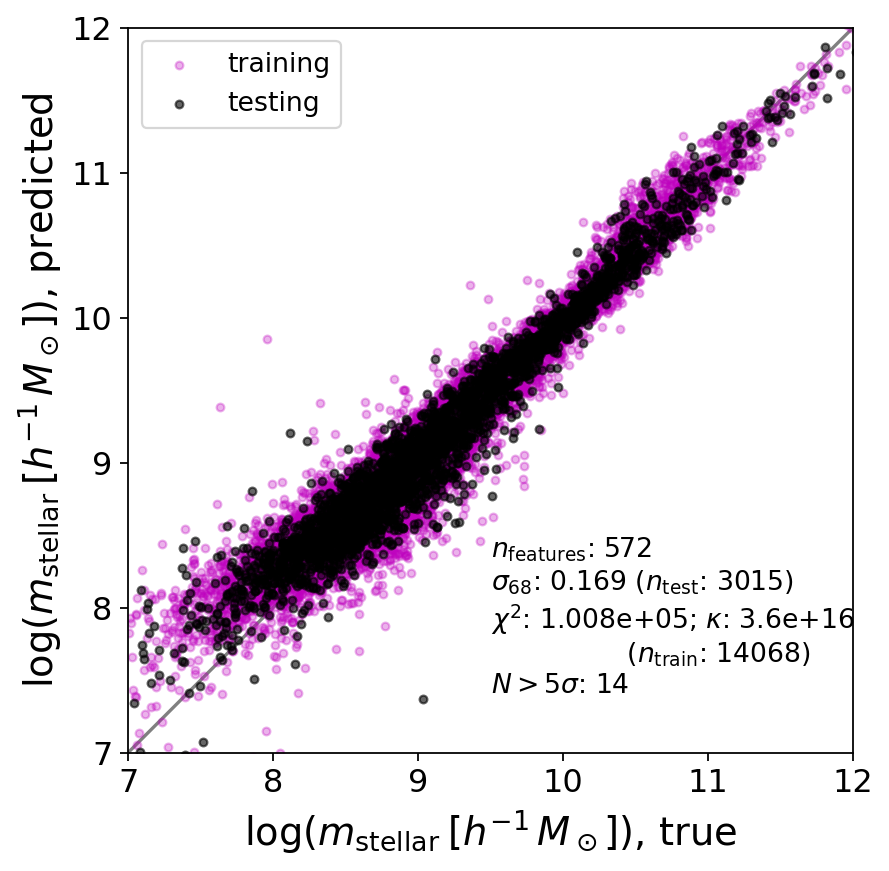

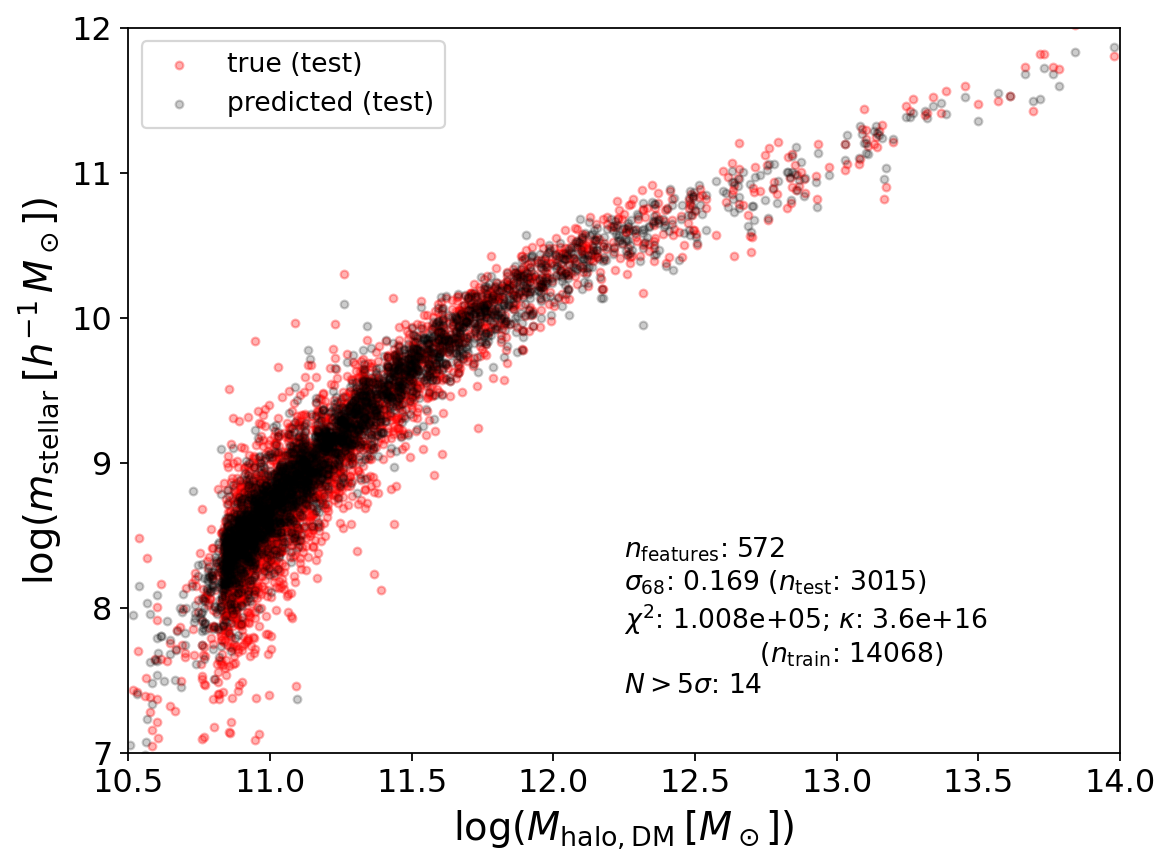

In [22]:
fitter = LinearFitter(scalar_featurizer.scalar_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test(idx_train, idx_val)
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
plotter.plot_fits(fitter, log_m_200m)

In [23]:
chi2_all = fitter.chi2
error_all, n_outliers_all = utils.compute_error(fitter, test_error_type='percentile')
print(error_all)

0.16885249504971236


# Feature importance

In [24]:
feature_imp_dir = f'../data/feature_importance/feature_importance_{sim_name}'
feature_tag = '_mstellar'
fn_feature_imp = f'{feature_imp_dir}/feature_importance{halo_tag}{geo_tag}{scalar_tag}{feature_tag}.npy'
feature_imp_results = feature_importance.load_feature_importance(fn_feature_imp)
idxs_ordered_best, errors_best, chi2s_best, groups = feature_imp_results

In [25]:
for i, idx in enumerate(idxs_ordered_best):
    display(Markdown(f'{i}: {errors_best[i]:.8f}: {scalar_name(s_feats[idx], geo_feature_arr_pseudo)}'))

0: 0.19431284: $[C^{xx}_0]_{jk} \, [C^{xx}_1]_{jk}$

1: 0.18935600: $[\frac{1}{2} (C^{xv} - C^{vx})_0]_{jk} \, [\frac{1}{2} (C^{xv} - C^{vx})_0]_{jk}$

2: 0.18398373: $m_0 \, m_0$

3: 0.17701406: $[C^{xx}_0]_{jk} \, [C^{xx}_0]_{jk}$

4: 0.17556443: $[C^{xx}_0]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk}$

5: 0.17479383: $m_0 \, m_1$

6: 0.17403033: $[x_0]_{j} \, [x_0]_{j}$

7: 0.17367146: $[\frac{1}{2} (C^{xv} - C^{vx})_0]_{jk} \, [\frac{1}{2} (C^{xv} - C^{vx})_2]_{jk}$

8: 0.17347784: $[\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk} \, [C^{xx}_2]_{jk}$

9: 0.17322818: $[C^{xx}_2]_{jk} \, [C^{xx}_2]_{jk}$

10: 0.17311842: $[\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk} \, [C^{xx}_0]_{jk}$

11: 0.17311110: $[\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk}$

12: 0.17307844: $[\frac{1}{2} (C^{xv} - C^{vx})_2]_{jk} \, [\frac{1}{2} (C^{xv} - C^{vx})_2]_{jk}$

13: 0.17281308: $[C^{xx}_1]_{jk} \, [C^{vv}_2]_{jk}$

14: 0.17281276: $[C^{vv}_1]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk}$

15: 0.17281276: $m_0 \, \lambda_1(C^{vv}_0)$

16: 0.17281276: $m_0 \, \lambda_2(C^{vv}_0)$

17: 0.17281276: $m_0 \, \lambda_3(C^{vv}_0)$

18: 0.17281276: $\lambda_1(C^{vv}_0) \, m_1$

19: 0.17281276: $\lambda_3(C^{vv}_0) \, m_1$

20: 0.17281276: $m_0 \, \lambda_3(C^{vv}_1)$

21: 0.17281276: $m_0 \, \lambda_2(C^{vv}_1)$

22: 0.17281276: $\lambda_2(C^{vv}_0) \, m_1$

23: 0.17281276: $m_0 \, \lambda_1(C^{vv}_1)$

24: 0.17281276: $\lambda_2(C^{vv}_0) \, \lambda_2(C^{vv}_0)$

25: 0.17281276: $\lambda_2(C^{vv}_0) \, \lambda_1(C^{vv}_0)$

26: 0.17281276: $\lambda_1(C^{vv}_0) \, \lambda_1(C^{vv}_0)$

27: 0.17281276: $\lambda_3(C^{vv}_0) \, \lambda_3(C^{vv}_0)$

28: 0.17281275: $\lambda_1(C^{vv}_0) \, \lambda_1(C^{vv}_1)$

29: 0.17281276: $\lambda_3(C^{vv}_0) \, \lambda_2(C^{vv}_0)$

30: 0.17281277: $\lambda_3(C^{vv}_0) \, \lambda_1(C^{vv}_0)$

31: 0.17281275: $m_0 \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

32: 0.17281275: $\lambda_3(C^{vv}_0) \, \lambda_3(C^{vv}_1)$

33: 0.17281275: $m_0 \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

34: 0.17281275: $m_0 \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

35: 0.17281273: $\lambda_3(C^{vv}_0) \, \lambda_2(C^{vv}_1)$

36: 0.17281276: $\lambda_1(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

37: 0.17281276: $\lambda_3(C^{vv}_0) \, \lambda_1(C^{vv}_1)$

38: 0.17281276: $\lambda_1(C^{vv}_0) \, \lambda_2(C^{vv}_1)$

39: 0.17281274: $\lambda_1(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

40: 0.17281273: $\lambda_2(C^{vv}_0) \, \lambda_3(C^{vv}_1)$

41: 0.17281275: $\lambda_1(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

42: 0.17281271: $\lambda_2(C^{vv}_0) \, \lambda_1(C^{vv}_1)$

43: 0.17281273: $\lambda_1(C^{vv}_0) \, \lambda_3(C^{vv}_1)$

44: 0.17281272: $\lambda_2(C^{vv}_0) \, \lambda_2(C^{vv}_1)$

45: 0.17281273: $m_0 \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

46: 0.17281276: $m_0 \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

47: 0.17281272: $\lambda_2(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

48: 0.17281278: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, m_1$

49: 0.17281274: $m_0 \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

50: 0.17281273: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, m_1$

51: 0.17281270: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, m_1$

52: 0.17281272: $\lambda_1(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

53: 0.17281274: $\lambda_3(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

54: 0.17281270: $\lambda_3(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

55: 0.17281272: $\lambda_2(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

56: 0.17281271: $\lambda_1(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

57: 0.17281274: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{vv}_1)$

58: 0.17281277: $\lambda_2(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

59: 0.17281281: $\lambda_3(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

60: 0.17281274: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{vv}_1)$

61: 0.17281271: $\lambda_3(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

62: 0.17281274: $\lambda_2(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

63: 0.17281276: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{vv}_1)$

64: 0.17281272: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{vv}_1)$

65: 0.17281274: $m_0 \, \lambda_3(C^{xx}_0)$

66: 0.17281270: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{vv}_1)$

67: 0.17281275: $\lambda_1(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

68: 0.17281275: $m_0 \, \lambda_2(C^{xx}_0)$

69: 0.17281275: $\lambda_3(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

70: 0.17281270: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{vv}_1)$

71: 0.17281273: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{vv}_1)$

72: 0.17281275: $m_0 \, \lambda_1(C^{xx}_0)$

73: 0.17281277: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{vv}_1)$

74: 0.17281261: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{vv}_1)$

75: 0.17281274: $\lambda_2(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

76: 0.17281272: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

77: 0.17281267: $\lambda_2(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

78: 0.17281271: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

79: 0.17281274: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

80: 0.17281272: $\lambda_3(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

81: 0.17281255: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

82: 0.17281265: $\lambda_1(C^{vv}_0) \, \lambda_2(C^{xx}_0)$

83: 0.17281265: $\lambda_1(C^{xx}_0) \, m_1$

84: 0.17281276: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

85: 0.17281269: $\lambda_1(C^{vv}_0) \, \lambda_1(C^{xx}_0)$

86: 0.17281280: $\lambda_2(C^{vv}_0) \, \lambda_1(C^{xx}_0)$

87: 0.17281259: $\lambda_3(C^{xx}_0) \, m_1$

88: 0.17281271: $\lambda_2(C^{vv}_0) \, \lambda_2(C^{xx}_0)$

89: 0.17281272: $\lambda_2(C^{vv}_0) \, \lambda_3(C^{xx}_0)$

90: 0.17281266: $\lambda_3(C^{vv}_0) \, \lambda_1(C^{xx}_0)$

91: 0.17281274: $\lambda_2(C^{xx}_0) \, m_1$

92: 0.17281278: $\lambda_3(C^{vv}_0) \, \lambda_2(C^{xx}_0)$

93: 0.17281280: $m_0 \, \lambda_1(C^{xx}_1)$

94: 0.17281261: $m_0 \, \lambda_3(C^{xx}_1)$

95: 0.17281269: $\lambda_3(C^{vv}_0) \, \lambda_3(C^{xx}_0)$

96: 0.17281255: $m_0 \, \lambda_2(C^{xx}_1)$

97: 0.17281268: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

98: 0.17281267: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

99: 0.17281269: $\lambda_2(C^{xx}_0) \, \lambda_3(C^{vv}_1)$

100: 0.17281270: $\lambda_1(C^{vv}_0) \, \lambda_3(C^{xx}_0)$

101: 0.17281256: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_0)$

102: 0.17281267: $\lambda_1(C^{vv}_0) \, \lambda_3(C^{xx}_1)$

103: 0.17281284: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_0)$

104: 0.17281263: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_0)$

105: 0.17281263: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_0)$

106: 0.17281267: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_0)$

107: 0.17281275: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_0)$

108: 0.17281270: $\lambda_1(C^{vv}_0) \, \lambda_2(C^{xx}_1)$

109: 0.17281273: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_0)$

110: 0.17281285: $\lambda_1(C^{vv}_0) \, \lambda_1(C^{xx}_1)$

111: 0.17281281: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

112: 0.17281274: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

113: 0.17281279: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_0)$

114: 0.17281268: $\lambda_2(C^{vv}_0) \, \lambda_1(C^{xx}_1)$

115: 0.17281280: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_0)$

116: 0.17281280: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

117: 0.17281281: $\lambda_2(C^{xx}_0) \, \lambda_1(C^{xx}_0)$

118: 0.17281261: $\lambda_3(C^{xx}_0) \, \lambda_3(C^{xx}_0)$

119: 0.17281284: $\lambda_3(C^{xx}_0) \, \lambda_2(C^{xx}_0)$

120: 0.17281273: $\lambda_2(C^{xx}_0) \, \lambda_1(C^{vv}_1)$

121: 0.17281265: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

122: 0.17281259: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

123: 0.17281255: $\lambda_1(C^{xx}_0) \, \lambda_1(C^{xx}_0)$

124: 0.17281287: $\lambda_3(C^{xx}_0) \, \lambda_1(C^{xx}_0)$

125: 0.17281265: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

126: 0.17281274: $\lambda_2(C^{xx}_0) \, \lambda_2(C^{xx}_0)$

127: 0.17281259: $\lambda_2(C^{xx}_0) \, \lambda_2(C^{vv}_1)$

128: 0.17281283: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

129: 0.17281250: $\lambda_3(C^{xx}_0) \, \lambda_3(C^{vv}_1)$

130: 0.17281262: $\lambda_2(C^{vv}_0) \, \lambda_3(C^{xx}_1)$

131: 0.17281267: $\lambda_2(C^{vv}_0) \, \lambda_2(C^{xx}_1)$

132: 0.17281267: $\lambda_3(C^{vv}_0) \, \lambda_3(C^{xx}_1)$

133: 0.17281260: $\lambda_3(C^{vv}_0) \, \lambda_2(C^{xx}_1)$

134: 0.17281284: $\lambda_3(C^{vv}_0) \, \lambda_1(C^{xx}_1)$

135: 0.17281288: $\lambda_3(C^{xx}_0) \, \lambda_2(C^{vv}_1)$

136: 0.17281282: $\lambda_3(C^{xx}_0) \, \lambda_1(C^{vv}_1)$

137: 0.17281275: $\lambda_1(C^{xx}_0) \, \lambda_1(C^{vv}_1)$

138: 0.17281240: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

139: 0.17281290: $\lambda_1(C^{xx}_0) \, \lambda_2(C^{vv}_1)$

140: 0.17281286: $\lambda_1(C^{xx}_0) \, \lambda_3(C^{vv}_1)$

141: 0.17281268: $\lambda_3(C^{xx}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

142: 0.17281265: $\lambda_3(C^{xx}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

143: 0.17281278: $\lambda_3(C^{xx}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

144: 0.17281244: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_1)$

145: 0.17281256: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_1)$

146: 0.17281268: $\lambda_2(C^{xx}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

147: 0.17281276: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_1)$

148: 0.17281330: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_1)$

149: 0.17281309: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_1)$

150: 0.17281270: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_1)$

151: 0.17281241: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_1)$

152: 0.17281254: $\lambda_2(C^{xx}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

153: 0.17281309: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_1)$

154: 0.17281267: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_1)$

155: 0.17281225: $\lambda_2(C^{xx}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

156: 0.17281258: $\lambda_1(C^{xx}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

157: 0.17281279: $\lambda_1(C^{xx}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

158: 0.17281221: $\lambda_1(C^{xx}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

159: 0.17281254: $\lambda_2(C^{xx}_0) \, \lambda_2(C^{xx}_1)$

160: 0.17281293: $\lambda_3(C^{xx}_0) \, \lambda_2(C^{xx}_1)$

161: 0.17281286: $\lambda_3(C^{xx}_0) \, \lambda_3(C^{xx}_1)$

162: 0.17281327: $\lambda_1(C^{xx}_0) \, \lambda_3(C^{xx}_1)$

163: 0.17281219: $\lambda_1(C^{xx}_0) \, \lambda_2(C^{xx}_1)$

164: 0.17281279: $\lambda_2(C^{xx}_0) \, \lambda_3(C^{xx}_1)$

165: 0.17281252: $\lambda_2(C^{xx}_0) \, \lambda_1(C^{xx}_1)$

166: 0.17281209: $\lambda_3(C^{xx}_0) \, \lambda_1(C^{xx}_1)$

167: 0.17281303: $\lambda_1(C^{xx}_0) \, \lambda_1(C^{xx}_1)$

168: 0.17294359: $[x_0]_{j} \, [v_1]_{j}$

169: 0.17292218: $[C^{vv}_1]_{jk} \, [C^{xx}_1]_{jk}$

170: 0.17289829: $[C^{vv}_0]_{jk} \, [C^{xx}_0]_{jk}$

171: 0.17281881: $[v_0]_{j} \, [v_1]_{j}$

172: 0.17216660: $[v_2]_{j} \, [v_2]_{j}$

173: 0.17120321: $[\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk}$

174: 0.16997316: $[C^{xx}_0]_{jk} \, [C^{vv}_1]_{jk}$

175: 0.16926683: $[C^{vv}_0]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk}$

176: 0.16829970: $[C^{xx}_0]_{jk} \, [C^{vv}_2]_{jk}$

177: 0.16796300: $[\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk} \, [C^{xx}_1]_{jk}$

178: 0.16787703: $[\frac{1}{2} (C^{xv} - C^{vx})_1]_{jk} \, [\frac{1}{2} (C^{xv} - C^{vx})_2]_{jk}$

179: 0.16777767: $[C^{vv}_1]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk}$

180: 0.16773316: $[v_1]_{j} \, [x_1]_{j}$

181: 0.16782745: $[x_0]_{j} \, [x_1]_{j}$

182: 0.16789851: $[C^{vv}_0]_{jk} \, [C^{vv}_0]_{jk}$

183: 0.16787567: $[C^{vv}_0]_{jk} \, [C^{xx}_2]_{jk}$

184: 0.16781956: $[x_1]_{j} \, [x_1]_{j}$

185: 0.16725431: $[v_1]_{j} \, [v_2]_{j}$

186: 0.16671556: $[v_1]_{j} \, [x_2]_{j}$

187: 0.16660218: $[C^{vv}_0]_{jk} \, [C^{vv}_1]_{jk}$

188: 0.16657184: $[\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk}$

189: 0.16647364: $m_2 \, m_2$

190: 0.16647490: $m_2 \, \lambda_3(C^{vv}_2)$

191: 0.16647392: $m_2 \, \lambda_2(C^{vv}_2)$

192: 0.16647412: $m_2 \, \lambda_1(C^{vv}_2)$

193: 0.16647444: $\lambda_2(C^{vv}_2) \, \lambda_2(C^{vv}_2)$

194: 0.16647426: $\lambda_3(C^{vv}_2) \, \lambda_2(C^{vv}_2)$

195: 0.16647407: $\lambda_3(C^{vv}_2) \, \lambda_3(C^{vv}_2)$

196: 0.16647377: $\lambda_3(C^{vv}_2) \, \lambda_1(C^{vv}_2)$

197: 0.16647397: $\lambda_1(C^{vv}_2) \, \lambda_1(C^{vv}_2)$

198: 0.16647423: $\lambda_2(C^{vv}_2) \, \lambda_1(C^{vv}_2)$

199: 0.16647368: $m_2 \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

200: 0.16647448: $m_2 \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

201: 0.16647454: $m_2 \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

202: 0.16647380: $\lambda_1(C^{vv}_2) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

203: 0.16647438: $\lambda_1(C^{vv}_2) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

204: 0.16647372: $\lambda_1(C^{vv}_2) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

205: 0.16647402: $\lambda_2(C^{vv}_2) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

206: 0.16647452: $\lambda_2(C^{vv}_2) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

207: 0.16647464: $\lambda_2(C^{vv}_2) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

208: 0.16647459: $\lambda_3(C^{vv}_2) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

209: 0.16647368: $\lambda_3(C^{vv}_2) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

210: 0.16647413: $\lambda_3(C^{vv}_2) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

211: 0.16647425: $m_2 \, \lambda_3(C^{xx}_2)$

212: 0.16647428: $m_2 \, \lambda_1(C^{xx}_2)$

213: 0.16647416: $m_2 \, \lambda_2(C^{xx}_2)$

214: 0.16647483: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

215: 0.16647445: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

216: 0.16647427: $\lambda_3(C^{vv}_2) \, \lambda_2(C^{xx}_2)$

217: 0.16647439: $\lambda_3(C^{vv}_2) \, \lambda_3(C^{xx}_2)$

218: 0.16647404: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

219: 0.16647340: $\lambda_2(C^{vv}_2) \, \lambda_1(C^{xx}_2)$

220: 0.16647397: $\lambda_1(C^{vv}_2) \, \lambda_1(C^{xx}_2)$

221: 0.16647415: $\lambda_2(C^{vv}_2) \, \lambda_2(C^{xx}_2)$

222: 0.16647381: $\lambda_2(C^{vv}_2) \, \lambda_3(C^{xx}_2)$

223: 0.16647366: $\lambda_3(C^{vv}_2) \, \lambda_1(C^{xx}_2)$

224: 0.16647417: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

225: 0.16647402: $\lambda_1(C^{vv}_2) \, \lambda_3(C^{xx}_2)$

226: 0.16647457: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

227: 0.16647390: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

228: 0.16647434: $\lambda_1(C^{vv}_2) \, \lambda_2(C^{xx}_2)$

229: 0.16647425: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_1(C^{xx}_2)$

230: 0.16647400: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_2(C^{xx}_2)$

231: 0.16647500: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_3(C^{xx}_2)$

232: 0.16647448: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_3(C^{xx}_2)$

233: 0.16647459: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_2(C^{xx}_2)$

234: 0.16647376: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_1(C^{xx}_2)$

235: 0.16647431: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_2(C^{xx}_2)$

236: 0.16647371: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_1(C^{xx}_2)$

237: 0.16647356: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2) \, \lambda_3(C^{xx}_2)$

238: 0.16647397: $\lambda_3(C^{xx}_2) \, \lambda_3(C^{xx}_2)$

239: 0.16647432: $\lambda_3(C^{xx}_2) \, \lambda_2(C^{xx}_2)$

240: 0.16647481: $\lambda_1(C^{xx}_2) \, \lambda_1(C^{xx}_2)$

241: 0.16647447: $\lambda_2(C^{xx}_2) \, \lambda_1(C^{xx}_2)$

242: 0.16647492: $\lambda_3(C^{xx}_2) \, \lambda_1(C^{xx}_2)$

243: 0.16647416: $\lambda_2(C^{xx}_2) \, \lambda_2(C^{xx}_2)$

244: 0.16660868: $[x_2]_{j} \, [x_2]_{j}$

245: 0.16664064: $[\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk} \, [C^{xx}_1]_{jk}$

246: 0.16670263: $[v_0]_{j} \, [v_0]_{j}$

247: 0.16664197: $[v_1]_{j} \, [v_1]_{j}$

248: 0.16664311: $[v_0]_{j} \, [v_2]_{j}$

249: 0.16679363: $[C^{xx}_0]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk}$

250: 0.16668025: $[C^{vv}_1]_{jk} \, [C^{vv}_2]_{jk}$

251: 0.16636134: $[C^{vv}_2]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk}$

252: 0.16628544: $[C^{vv}_2]_{jk} \, [C^{xx}_2]_{jk}$

253: 0.16625571: $[C^{vv}_1]_{jk} \, [C^{xx}_2]_{jk}$

254: 0.16626409: $[\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk} \, [C^{xx}_2]_{jk}$

255: 0.16630417: $[C^{vv}_0]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk}$

256: 0.16629716: $[\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk} \, [C^{vv}_2]_{jk}$

257: 0.16631690: $[\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk} \, [C^{xx}_2]_{jk}$

258: 0.16635226: $[C^{vv}_0]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk}$

259: 0.16638289: $[\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk} \, [C^{vv}_2]_{jk}$

260: 0.16636760: $[\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk} \, [C^{vv}_1]_{jk}$

261: 0.16627872: $[C^{vv}_2]_{jk} \, [C^{vv}_2]_{jk}$

262: 0.16642048: $[C^{vv}_0]_{jk} \, [C^{xx}_1]_{jk}$

263: 0.16633244: $[\frac{1}{2} (C^{xv} + C^{vx})_1]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk}$

264: 0.16630713: $[x_0]_{j} \, [v_2]_{j}$

265: 0.16609369: $[C^{xx}_1]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk}$

266: 0.16599462: $[C^{xx}_0]_{jk} \, [C^{xx}_2]_{jk}$

267: 0.16602195: $[\frac{1}{2} (C^{xv} + C^{vx})_0]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk}$

268: 0.16620889: $[v_0]_{j} \, [x_0]_{j}$

269: 0.16639663: $[x_0]_{j} \, [x_2]_{j}$

270: 0.16696398: $[C^{vv}_0]_{jk} \, [C^{vv}_2]_{jk}$

271: 0.16672405: $[\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk} \, [\frac{1}{2} (C^{xv} + C^{vx})_2]_{jk}$

272: 0.16721489: $[x_1]_{j} \, [x_2]_{j}$

273: 0.16715968: $[C^{xx}_1]_{jk} \, [C^{xx}_2]_{jk}$

274: 0.16706328: $[C^{xx}_1]_{jk} \, [C^{xx}_1]_{jk}$

275: 0.16724030: $[v_0]_{j} \, [x_2]_{j}$

276: 0.16707557: $m_1 \, m_2$

277: 0.16707561: $m_1 \, \lambda_3(C^{vv}_2)$

278: 0.16707558: $m_1 \, \lambda_2(C^{vv}_2)$

279: 0.16707563: $m_1 \, \lambda_1(C^{vv}_2)$

280: 0.16707548: $\lambda_3(C^{vv}_1) \, m_2$

281: 0.16707562: $\lambda_2(C^{vv}_1) \, m_2$

282: 0.16707562: $\lambda_1(C^{vv}_1) \, m_2$

283: 0.16707564: $\lambda_2(C^{vv}_1) \, \lambda_2(C^{vv}_2)$

284: 0.16707562: $\lambda_2(C^{vv}_1) \, \lambda_3(C^{vv}_2)$

285: 0.16707555: $\lambda_3(C^{vv}_1) \, \lambda_2(C^{vv}_2)$

286: 0.16707564: $\lambda_2(C^{vv}_1) \, \lambda_1(C^{vv}_2)$

287: 0.16707552: $\lambda_3(C^{vv}_1) \, \lambda_1(C^{vv}_2)$

288: 0.16707559: $\lambda_3(C^{vv}_1) \, \lambda_3(C^{vv}_2)$

289: 0.16707561: $\lambda_1(C^{vv}_1) \, \lambda_1(C^{vv}_2)$

290: 0.16707565: $\lambda_1(C^{vv}_1) \, \lambda_2(C^{vv}_2)$

291: 0.16707566: $\lambda_1(C^{vv}_1) \, \lambda_3(C^{vv}_2)$

292: 0.16707557: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, m_2$

293: 0.16707553: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, m_2$

294: 0.16707558: $m_1 \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

295: 0.16707558: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, m_2$

296: 0.16707568: $m_1 \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

297: 0.16707562: $m_1 \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

298: 0.16707577: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(C^{vv}_2)$

299: 0.16707558: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(C^{vv}_2)$

300: 0.16707552: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(C^{vv}_2)$

301: 0.16707566: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(C^{vv}_2)$

302: 0.16707561: $\lambda_2(C^{vv}_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

303: 0.16707574: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(C^{vv}_2)$

304: 0.16707552: $\lambda_2(C^{vv}_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

305: 0.16707564: $\lambda_2(C^{vv}_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

306: 0.16707564: $\lambda_3(C^{vv}_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

307: 0.16707561: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(C^{vv}_2)$

308: 0.16707559: $\lambda_3(C^{vv}_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

309: 0.16707568: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(C^{vv}_2)$

310: 0.16707556: $\lambda_1(C^{vv}_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

311: 0.16707564: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(C^{vv}_2)$

312: 0.16707559: $\lambda_1(C^{vv}_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

313: 0.16707567: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(C^{vv}_2)$

314: 0.16707567: $\lambda_1(C^{vv}_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

315: 0.16707569: $\lambda_3(C^{vv}_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

316: 0.16707577: $\lambda_2(C^{xx}_1) \, m_2$

317: 0.16707544: $\lambda_1(C^{xx}_1) \, m_2$

318: 0.16707582: $m_1 \, \lambda_1(C^{xx}_2)$

319: 0.16707581: $m_1 \, \lambda_2(C^{xx}_2)$

320: 0.16707561: $\lambda_3(C^{xx}_1) \, m_2$

321: 0.16707563: $m_1 \, \lambda_3(C^{xx}_2)$

322: 0.16707576: $\lambda_1(C^{vv}_1) \, \lambda_2(C^{xx}_2)$

323: 0.16707561: $\lambda_1(C^{vv}_1) \, \lambda_1(C^{xx}_2)$

324: 0.16707562: $\lambda_1(C^{vv}_1) \, \lambda_3(C^{xx}_2)$

325: 0.16707575: $\lambda_3(C^{xx}_1) \, \lambda_2(C^{vv}_2)$

326: 0.16707565: $\lambda_2(C^{xx}_1) \, \lambda_1(C^{vv}_2)$

327: 0.16707562: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

328: 0.16707550: $\lambda_2(C^{xx}_1) \, \lambda_2(C^{vv}_2)$

329: 0.16707565: $\lambda_3(C^{xx}_1) \, \lambda_3(C^{vv}_2)$

330: 0.16707573: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

331: 0.16707568: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

332: 0.16707570: $\lambda_2(C^{xx}_1) \, \lambda_3(C^{vv}_2)$

333: 0.16724221: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

334: 0.16724221: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

335: 0.16724221: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

336: 0.16724221: $\lambda_3(C^{xx}_1) \, \lambda_1(C^{vv}_2)$

337: 0.16724221: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

338: 0.16724221: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

339: 0.16724221: $\lambda_3(C^{vv}_1) \, \lambda_3(C^{xx}_2)$

340: 0.16724221: $\lambda_3(C^{vv}_1) \, \lambda_2(C^{xx}_2)$

341: 0.16724221: $\lambda_3(C^{vv}_1) \, \lambda_1(C^{xx}_2)$

342: 0.16724221: $\lambda_1(C^{xx}_1) \, \lambda_2(C^{vv}_2)$

343: 0.16724221: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

344: 0.16724221: $\lambda_1(C^{xx}_1) \, \lambda_1(C^{vv}_2)$

345: 0.16724221: $\lambda_2(C^{vv}_1) \, \lambda_2(C^{xx}_2)$

346: 0.16724221: $\lambda_2(C^{vv}_1) \, \lambda_1(C^{xx}_2)$

347: 0.16724221: $\lambda_1(C^{xx}_1) \, \lambda_3(C^{vv}_2)$

348: 0.16724221: $\lambda_2(C^{vv}_1) \, \lambda_3(C^{xx}_2)$

349: 0.16724221: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(C^{xx}_2)$

350: 0.16724221: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(C^{xx}_2)$

351: 0.16724221: $\lambda_3(C^{xx}_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

352: 0.16724221: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(C^{xx}_2)$

353: 0.16724221: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(C^{xx}_2)$

354: 0.16724221: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(C^{xx}_2)$

355: 0.16724221: $\lambda_3(C^{xx}_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

356: 0.16724221: $\lambda_3(C^{xx}_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

357: 0.16724221: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(C^{xx}_2)$

358: 0.16724221: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(C^{xx}_2)$

359: 0.16724221: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(C^{xx}_2)$

360: 0.16724221: $\lambda_2(C^{xx}_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

361: 0.16724221: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(C^{xx}_2)$

362: 0.16724221: $\lambda_2(C^{xx}_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

363: 0.16718633: $[v_2]_{j} \, [x_2]_{j}$

364: 0.16718633: $\lambda_1(C^{xx}_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

365: 0.16718633: $\lambda_1(C^{xx}_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

366: 0.16718633: $\lambda_1(C^{xx}_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

367: 0.16718633: $\lambda_2(C^{xx}_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

368: 0.16718633: $\lambda_3(C^{xx}_1) \, \lambda_3(C^{xx}_2)$

369: 0.16718633: $\lambda_3(C^{xx}_1) \, \lambda_2(C^{xx}_2)$

370: 0.16718633: $\lambda_3(C^{xx}_1) \, \lambda_1(C^{xx}_2)$

371: 0.16718633: $\lambda_2(C^{xx}_1) \, \lambda_3(C^{xx}_2)$

372: 0.16718633: $\lambda_2(C^{xx}_1) \, \lambda_2(C^{xx}_2)$

373: 0.16718633: $\lambda_2(C^{xx}_1) \, \lambda_1(C^{xx}_2)$

374: 0.16718633: $\lambda_1(C^{xx}_1) \, \lambda_3(C^{xx}_2)$

375: 0.16718633: $\lambda_1(C^{xx}_1) \, \lambda_2(C^{xx}_2)$

376: 0.16718633: $\lambda_1(C^{xx}_1) \, \lambda_1(C^{xx}_2)$

377: 0.16735523: $[v_0]_{j} \, [x_1]_{j}$

378: 0.16735233: $m_0$

379: 0.16722751: $[x_1]_{j} \, [v_2]_{j}$

380: 0.16722751: $\lambda_3(C^{vv}_0)$

381: 0.16722751: $\lambda_1(C^{vv}_0)$

382: 0.16722751: $\lambda_2(C^{vv}_0)$

383: 0.16722751: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

384: 0.16722751: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

385: 0.16722751: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

386: 0.16722751: $\lambda_2(C^{xx}_0)$

387: 0.16722751: $\lambda_3(C^{xx}_0)$

388: 0.16722751: $\lambda_1(C^{xx}_0)$

389: 0.16757628: $m_0 \, m_2$

390: 0.16757628: $m_0 \, \lambda_2(C^{vv}_2)$

391: 0.16757628: $\lambda_3(C^{vv}_0) \, m_2$

392: 0.16757628: $m_0 \, \lambda_3(C^{vv}_2)$

393: 0.16757628: $\lambda_1(C^{vv}_0) \, m_2$

394: 0.16757628: $\lambda_2(C^{vv}_0) \, m_2$

395: 0.16757628: $m_0 \, \lambda_1(C^{vv}_2)$

396: 0.16757628: $\lambda_2(C^{vv}_0) \, \lambda_3(C^{vv}_2)$

397: 0.16757628: $\lambda_3(C^{vv}_0) \, \lambda_1(C^{vv}_2)$

398: 0.16757628: $\lambda_3(C^{vv}_0) \, \lambda_2(C^{vv}_2)$

399: 0.16757628: $\lambda_1(C^{vv}_0) \, \lambda_2(C^{vv}_2)$

400: 0.16757628: $\lambda_1(C^{vv}_0) \, \lambda_1(C^{vv}_2)$

401: 0.16757628: $\lambda_2(C^{vv}_0) \, \lambda_2(C^{vv}_2)$

402: 0.16757628: $\lambda_2(C^{vv}_0) \, \lambda_1(C^{vv}_2)$

403: 0.16757628: $\lambda_1(C^{vv}_0) \, \lambda_3(C^{vv}_2)$

404: 0.16757628: $\lambda_3(C^{vv}_0) \, \lambda_3(C^{vv}_2)$

405: 0.16757628: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, m_2$

406: 0.16757628: $m_0 \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

407: 0.16757628: $m_0 \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

408: 0.16757628: $m_0 \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

409: 0.16757628: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, m_2$

410: 0.16757628: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, m_2$

411: 0.16757628: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{vv}_2)$

412: 0.16757628: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{vv}_2)$

413: 0.16757628: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{vv}_2)$

414: 0.16757628: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{vv}_2)$

415: 0.16757628: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{vv}_2)$

416: 0.16757628: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{vv}_2)$

417: 0.16757628: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{vv}_2)$

418: 0.16757628: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{vv}_2)$

419: 0.16757628: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{vv}_2)$

420: 0.16757628: $\lambda_3(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

421: 0.16757628: $\lambda_3(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

422: 0.16757628: $\lambda_3(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

423: 0.16757628: $\lambda_2(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

424: 0.16757628: $\lambda_2(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

425: 0.16757628: $\lambda_2(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

426: 0.16757628: $\lambda_1(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

427: 0.16757628: $\lambda_1(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

428: 0.16757628: $\lambda_1(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

429: 0.16757628: $\lambda_3(C^{xx}_0) \, m_2$

430: 0.16757628: $\lambda_1(C^{xx}_0) \, m_2$

431: 0.16757628: $m_0 \, \lambda_1(C^{xx}_2)$

432: 0.16757628: $m_0 \, \lambda_2(C^{xx}_2)$

433: 0.16757628: $m_0 \, \lambda_3(C^{xx}_2)$

434: 0.16757628: $\lambda_2(C^{xx}_0) \, m_2$

435: 0.16757628: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

436: 0.16757628: $\lambda_3(C^{xx}_0) \, \lambda_3(C^{vv}_2)$

437: 0.16757628: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

438: 0.16757628: $\lambda_3(C^{vv}_0) \, \lambda_1(C^{xx}_2)$

439: 0.16757628: $\lambda_3(C^{vv}_0) \, \lambda_3(C^{xx}_2)$

440: 0.16757628: $\lambda_3(C^{vv}_0) \, \lambda_2(C^{xx}_2)$

441: 0.16757628: $\lambda_3(C^{xx}_0) \, \lambda_2(C^{vv}_2)$

442: 0.16757628: $\lambda_1(C^{vv}_0) \, \lambda_1(C^{xx}_2)$

443: 0.16757628: $\lambda_1(C^{vv}_0) \, \lambda_2(C^{xx}_2)$

444: 0.16757628: $\lambda_1(C^{vv}_0) \, \lambda_3(C^{xx}_2)$

445: 0.16757628: $\lambda_3(C^{xx}_0) \, \lambda_1(C^{vv}_2)$

446: 0.16757628: $\lambda_2(C^{vv}_0) \, \lambda_1(C^{xx}_2)$

447: 0.16757628: $\lambda_2(C^{vv}_0) \, \lambda_2(C^{xx}_2)$

448: 0.16757628: $\lambda_2(C^{vv}_0) \, \lambda_3(C^{xx}_2)$

449: 0.16757628: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

450: 0.16757628: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

451: 0.16757628: $\lambda_2(C^{xx}_0) \, \lambda_3(C^{vv}_2)$

452: 0.16757628: $\lambda_1(C^{xx}_0) \, \lambda_1(C^{vv}_2)$

453: 0.16757628: $\lambda_1(C^{xx}_0) \, \lambda_3(C^{vv}_2)$

454: 0.16757628: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

455: 0.16757628: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

456: 0.16757628: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

457: 0.16757628: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

458: 0.16757628: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

459: 0.16757628: $\lambda_1(C^{xx}_0) \, \lambda_2(C^{vv}_2)$

460: 0.16757628: $\lambda_2(C^{xx}_0) \, \lambda_2(C^{vv}_2)$

461: 0.16757628: $\lambda_2(C^{xx}_0) \, \lambda_1(C^{vv}_2)$

462: 0.16757628: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_2)$

463: 0.16757628: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_2)$

464: 0.16757628: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_2)$

465: 0.16757628: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_2)$

466: 0.16757628: $\lambda_3(C^{xx}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

467: 0.16757628: $\lambda_3(C^{xx}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

468: 0.16757628: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_2)$

469: 0.16757628: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_2)$

470: 0.16757628: $\lambda_2(C^{xx}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

471: 0.16757628: $\lambda_3(C^{xx}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

472: 0.16757628: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_2)$

473: 0.16757628: $\lambda_1(C^{xx}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

474: 0.16757628: $\lambda_2(C^{xx}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

475: 0.16757628: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_2)$

476: 0.16757628: $\lambda_1(C^{xx}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

477: 0.16757628: $\lambda_2(C^{xx}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

478: 0.16757628: $\lambda_1(C^{xx}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

479: 0.16757628: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_2)$

480: 0.16757628: $\lambda_2(C^{xx}_0) \, \lambda_3(C^{xx}_2)$

481: 0.16757628: $\lambda_3(C^{xx}_0) \, \lambda_1(C^{xx}_2)$

482: 0.16757628: $\lambda_3(C^{xx}_0) \, \lambda_3(C^{xx}_2)$

483: 0.16757628: $\lambda_3(C^{xx}_0) \, \lambda_2(C^{xx}_2)$

484: 0.16757628: $\lambda_2(C^{xx}_0) \, \lambda_2(C^{xx}_2)$

485: 0.16757628: $\lambda_2(C^{xx}_0) \, \lambda_1(C^{xx}_2)$

486: 0.16757628: $\lambda_1(C^{xx}_0) \, \lambda_3(C^{xx}_2)$

487: 0.16757628: $\lambda_1(C^{xx}_0) \, \lambda_2(C^{xx}_2)$

488: 0.16757628: $\lambda_1(C^{xx}_0) \, \lambda_1(C^{xx}_2)$

489: 0.16770750: $m_2$

490: 0.16769366: $[\frac{1}{2} (C^{xv} - C^{vx})_1]_{jk} \, [\frac{1}{2} (C^{xv} - C^{vx})_1]_{jk}$

491: 0.16769366: $\lambda_1(C^{vv}_2)$

492: 0.16769366: $\lambda_2(C^{vv}_2)$

493: 0.16769366: $\lambda_3(C^{vv}_2)$

494: 0.16769366: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_2)$

495: 0.16769366: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_2)$

496: 0.16769366: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_2)$

497: 0.16769366: $\lambda_2(C^{xx}_2)$

498: 0.16769366: $\lambda_1(C^{xx}_2)$

499: 0.16769366: $\lambda_3(C^{xx}_2)$

500: 0.16833965: $[C^{vv}_1]_{jk} \, [C^{vv}_1]_{jk}$

501: 0.16812042: $m_1$

502: 0.16812042: $\lambda_3(C^{vv}_1)$

503: 0.16812042: $\lambda_2(C^{vv}_1)$

504: 0.16812042: $\lambda_1(C^{vv}_1)$

505: 0.16812042: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

506: 0.16812042: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

507: 0.16812042: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

508: 0.16812042: $\lambda_3(C^{xx}_1)$

509: 0.16812042: $\lambda_2(C^{xx}_1)$

510: 0.16812042: $\lambda_1(C^{xx}_1)$

511: 0.16837038: $m_1 \, m_1$

512: 0.16837037: $m_1 \, \lambda_1(C^{vv}_1)$

513: 0.16837037: $m_1 \, \lambda_2(C^{vv}_1)$

514: 0.16837037: $m_1 \, \lambda_3(C^{vv}_1)$

515: 0.16837037: $\lambda_3(C^{vv}_1) \, \lambda_1(C^{vv}_1)$

516: 0.16837037: $\lambda_2(C^{vv}_1) \, \lambda_2(C^{vv}_1)$

517: 0.16837038: $\lambda_2(C^{vv}_1) \, \lambda_1(C^{vv}_1)$

518: 0.16837038: $\lambda_3(C^{vv}_1) \, \lambda_3(C^{vv}_1)$

519: 0.16837038: $\lambda_3(C^{vv}_1) \, \lambda_2(C^{vv}_1)$

520: 0.16837037: $\lambda_1(C^{vv}_1) \, \lambda_1(C^{vv}_1)$

521: 0.16837038: $m_1 \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

522: 0.16837038: $m_1 \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

523: 0.16837038: $m_1 \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

524: 0.16837038: $\lambda_3(C^{vv}_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

525: 0.16837037: $\lambda_3(C^{vv}_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

526: 0.16837037: $\lambda_3(C^{vv}_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

527: 0.16837038: $\lambda_1(C^{vv}_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

528: 0.16837038: $\lambda_2(C^{vv}_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

529: 0.16837037: $\lambda_1(C^{vv}_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

530: 0.16837038: $\lambda_1(C^{vv}_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

531: 0.16837037: $\lambda_2(C^{vv}_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

532: 0.16837038: $\lambda_2(C^{vv}_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

533: 0.16837037: $m_1 \, \lambda_3(C^{xx}_1)$

534: 0.16837038: $m_1 \, \lambda_1(C^{xx}_1)$

535: 0.16837038: $m_1 \, \lambda_2(C^{xx}_1)$

536: 0.16837038: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

537: 0.16837038: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

538: 0.16837038: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

539: 0.16837038: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1)$

540: 0.16837038: $\lambda_2(C^{vv}_1) \, \lambda_1(C^{xx}_1)$

541: 0.16837038: $\lambda_2(C^{vv}_1) \, \lambda_2(C^{xx}_1)$

542: 0.16837038: $\lambda_2(C^{vv}_1) \, \lambda_3(C^{xx}_1)$

543: 0.16837037: $\lambda_3(C^{vv}_1) \, \lambda_3(C^{xx}_1)$

544: 0.16837038: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1)$

545: 0.16837038: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1)$

546: 0.16837038: $\lambda_1(C^{vv}_1) \, \lambda_3(C^{xx}_1)$

547: 0.16837037: $\lambda_1(C^{vv}_1) \, \lambda_2(C^{xx}_1)$

548: 0.16837038: $\lambda_1(C^{vv}_1) \, \lambda_1(C^{xx}_1)$

549: 0.16837038: $\lambda_3(C^{vv}_1) \, \lambda_1(C^{xx}_1)$

550: 0.16837038: $\lambda_3(C^{vv}_1) \, \lambda_2(C^{xx}_1)$

551: 0.16837038: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(C^{xx}_1)$

552: 0.16837038: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(C^{xx}_1)$

553: 0.16837038: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(C^{xx}_1)$

554: 0.16837038: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(C^{xx}_1)$

555: 0.16837038: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(C^{xx}_1)$

556: 0.16837038: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_3(C^{xx}_1)$

557: 0.16837038: $\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(C^{xx}_1)$

558: 0.16837038: $\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_1(C^{xx}_1)$

559: 0.16837037: $\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_1) \, \lambda_2(C^{xx}_1)$

560: 0.16837037: $\lambda_3(C^{xx}_1) \, \lambda_3(C^{xx}_1)$

561: 0.16837038: $\lambda_2(C^{xx}_1) \, \lambda_2(C^{xx}_1)$

562: 0.16837038: $\lambda_2(C^{xx}_1) \, \lambda_1(C^{xx}_1)$

563: 0.16837037: $\lambda_1(C^{xx}_1) \, \lambda_1(C^{xx}_1)$

564: 0.16837038: $\lambda_3(C^{xx}_1) \, \lambda_2(C^{xx}_1)$

565: 0.16837037: $\lambda_3(C^{xx}_1) \, \lambda_1(C^{xx}_1)$

566: 0.16885264: $[\frac{1}{2} (C^{xv} - C^{vx})_0]_{jk} \, [\frac{1}{2} (C^{xv} - C^{vx})_1]_{jk}$

266


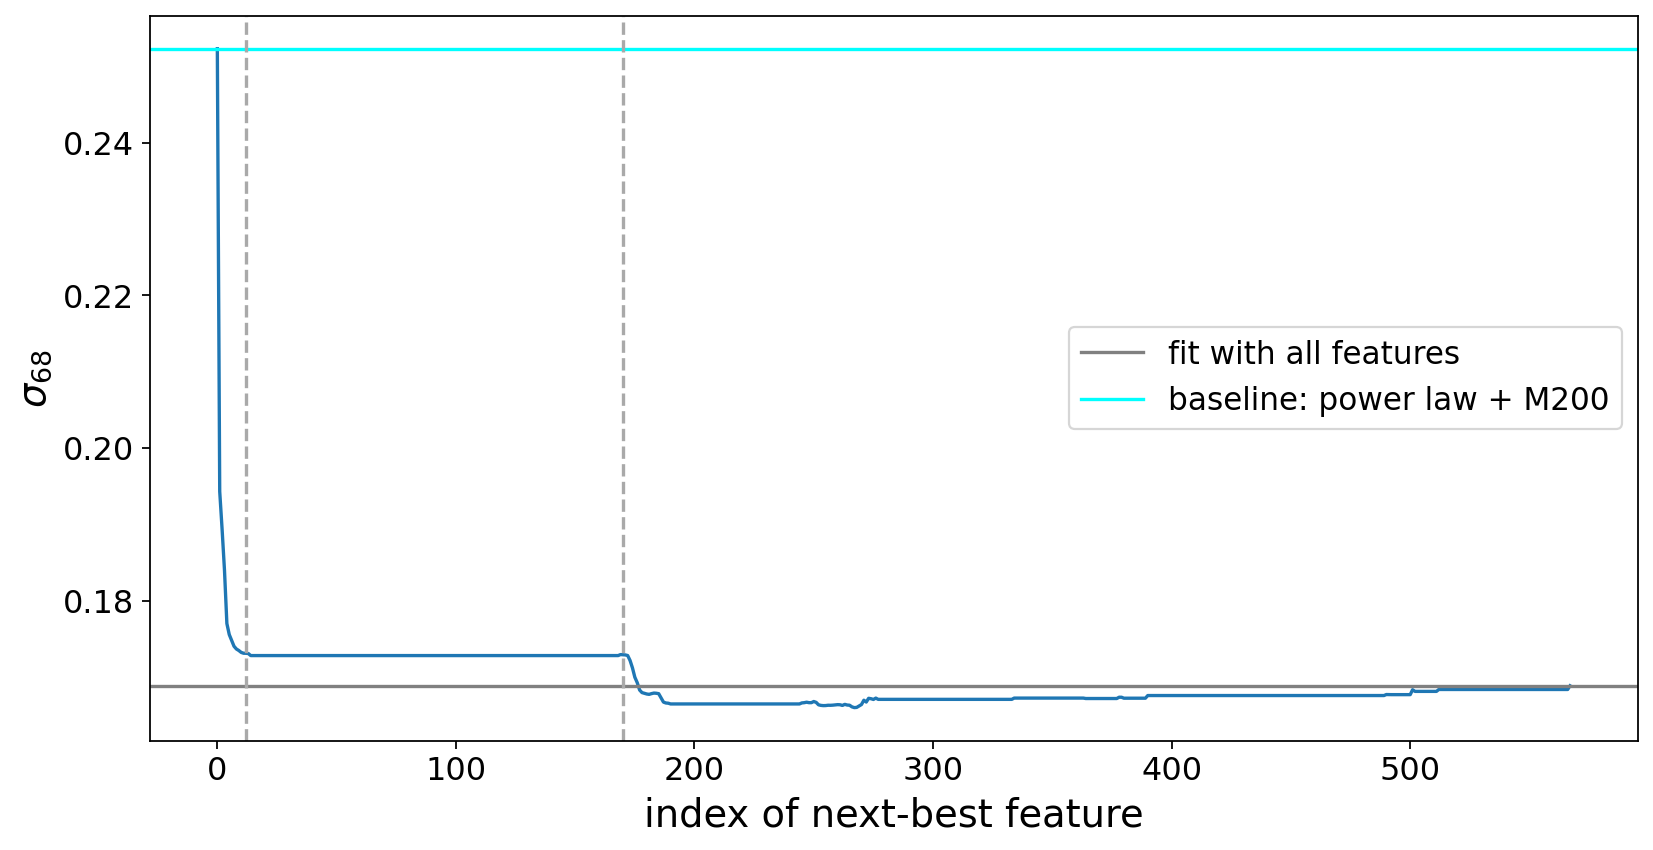

In [26]:
plt.figure(figsize=(12,6))
errors_best_withfirst = [error_powerlawM] + errors_best
plt.plot(errors_best_withfirst)
plt.axhline(error_all, color='grey', label='fit with all features')
#plt.axhline(error_powerlaw, color='magenta', label='fit with all')
plt.axhline(error_powerlawM, color='cyan', label='baseline: power law + M200')

n_min = np.argmin(errors_best)
plt.axvline(12, color='darkgrey', ls='--')
plt.axvline(170, color='darkgrey', ls='--')
#plt.axvline(n_min, color='darkgrey', ls='--')
print(n_min)
plt.xlabel('index of next-best feature')
plt.ylabel(r'$\sigma_{68}$')

plt.legend(fontsize=14)

266


(-1.0, 20.0)

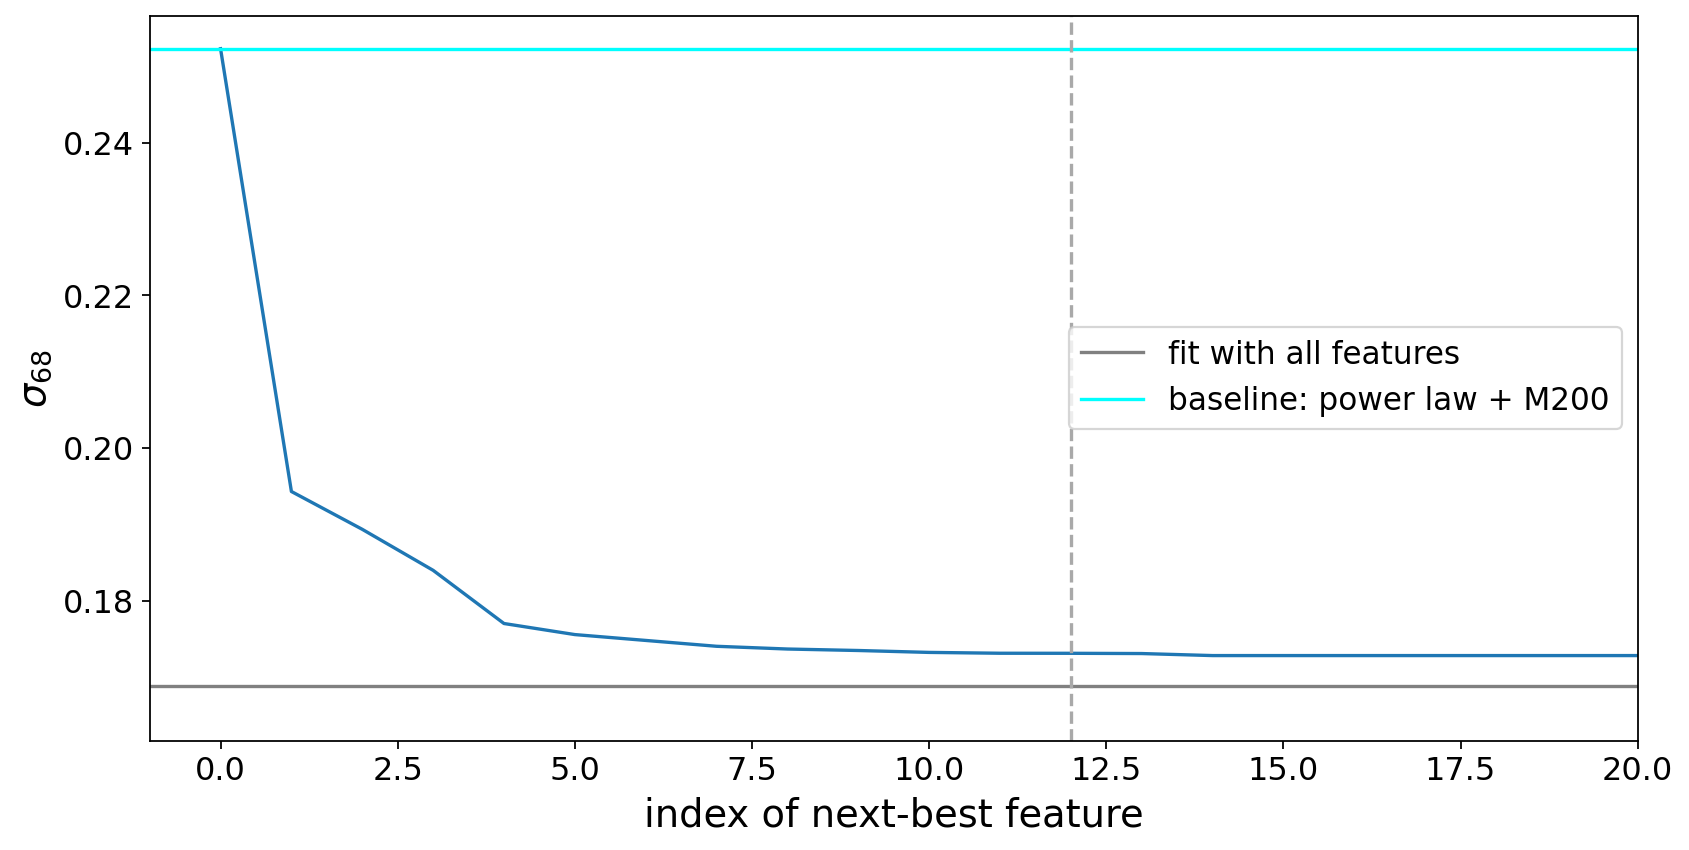

In [27]:
plt.figure(figsize=(12,6))
errors_best_withfirst = [error_powerlawM] + errors_best
plt.plot(errors_best_withfirst)
plt.axhline(error_all, color='grey', label='fit with all features')
#plt.axhline(error_powerlaw, color='magenta', label='fit with all')
plt.axhline(error_powerlawM, color='cyan', label='baseline: power law + M200')

n_min = np.argmin(errors_best)
#plt.axvline(5, color='darkgrey', ls='--')
plt.axvline(12, color='darkgrey', ls='--')
#plt.axvline(n_min, color='darkgrey', ls='--')
print(n_min)
plt.xlabel('index of next-best feature')
plt.ylabel(r'$\sigma_{68}$')

plt.legend(fontsize=14)

plt.xlim(-1,20)

In [28]:
for group in [groups[0]]:
    for idx in group:
        display(Markdown(scalar_name(s_feats[idx], geo_feature_arr_pseudo)))
    print()

$m_0 \, m_0$

$m_0 \, \lambda_1(C^{vv}_0)$

$m_0 \, \lambda_2(C^{vv}_0)$

$m_0 \, \lambda_3(C^{vv}_0)$

$\lambda_2(C^{vv}_0) \, \lambda_2(C^{vv}_0)$

$\lambda_2(C^{vv}_0) \, \lambda_1(C^{vv}_0)$

$\lambda_1(C^{vv}_0) \, \lambda_1(C^{vv}_0)$

$\lambda_3(C^{vv}_0) \, \lambda_3(C^{vv}_0)$

$\lambda_3(C^{vv}_0) \, \lambda_2(C^{vv}_0)$

$\lambda_3(C^{vv}_0) \, \lambda_1(C^{vv}_0)$

$m_0 \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$m_0 \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$m_0 \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_1(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_1(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_1(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_2(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_3(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_3(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_2(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_2(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_3(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$m_0 \, \lambda_3(C^{xx}_0)$

$m_0 \, \lambda_2(C^{xx}_0)$

$m_0 \, \lambda_1(C^{xx}_0)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_1(C^{vv}_0) \, \lambda_2(C^{xx}_0)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_1(C^{vv}_0) \, \lambda_1(C^{xx}_0)$

$\lambda_2(C^{vv}_0) \, \lambda_1(C^{xx}_0)$

$\lambda_2(C^{vv}_0) \, \lambda_2(C^{xx}_0)$

$\lambda_2(C^{vv}_0) \, \lambda_3(C^{xx}_0)$

$\lambda_3(C^{vv}_0) \, \lambda_1(C^{xx}_0)$

$\lambda_3(C^{vv}_0) \, \lambda_2(C^{xx}_0)$

$\lambda_3(C^{vv}_0) \, \lambda_3(C^{xx}_0)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_1(C^{vv}_0) \, \lambda_3(C^{xx}_0)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_0)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_0)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_0)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_0)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_0)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_0)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_0)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_0)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_0)$

$\lambda_2(C^{xx}_0) \, \lambda_1(C^{xx}_0)$

$\lambda_3(C^{xx}_0) \, \lambda_3(C^{xx}_0)$

$\lambda_3(C^{xx}_0) \, \lambda_2(C^{xx}_0)$

$\lambda_1(C^{xx}_0) \, \lambda_1(C^{xx}_0)$

$\lambda_3(C^{xx}_0) \, \lambda_1(C^{xx}_0)$

$\lambda_2(C^{xx}_0) \, \lambda_2(C^{xx}_0)$

### Visualize halos

In [29]:
nrows = 2
ncols = 3
n_plot = nrows * ncols

In [30]:
sim_reader.add_catalog_property_to_halos('r200m')
sim_reader.add_catalog_property_to_halos('x_minPE')
sim_reader.add_catalog_property_to_halos('x_minPE_hydro')
features_all = scalar_featurizer.scalar_features
feature_arr_all = scalar_featurizer.scalar_feature_arr

Text(0, 0.5, '$y_\\mathrm{pred} - y_\\mathrm{true}$')

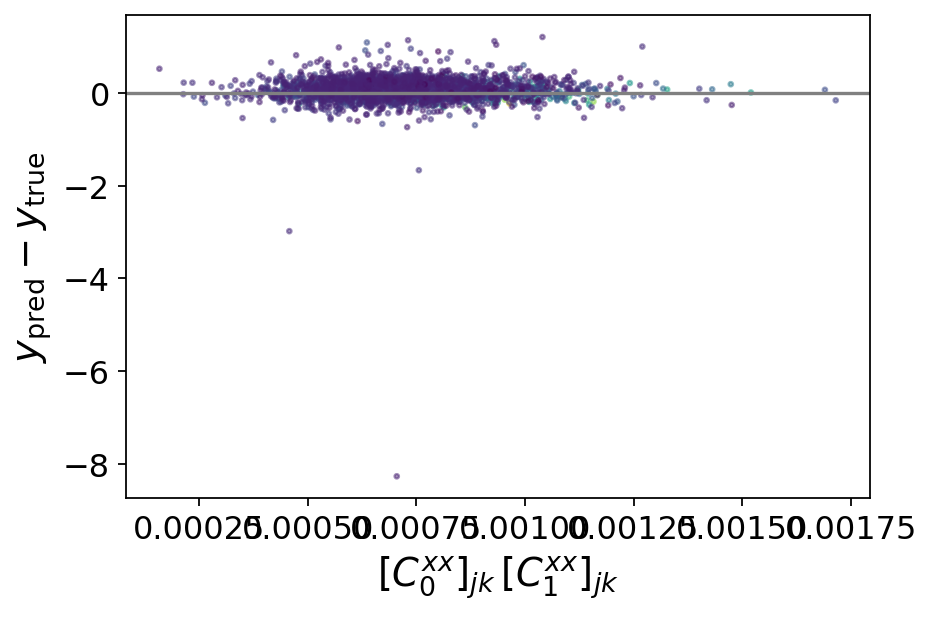

In [31]:
i_best = 0
idx_feat = idxs_ordered_best[i_best]
y_pred = fitter.y_scalar_pred
y_true = fitter.y_scalar_test
diffs = y_pred - y_true
plt.scatter(features_all[idx_test,idx_feat], diffs, c=log_m_200m[idx_test], s=4, alpha=0.5)
plt.axhline(0, color='grey')
plt.xlabel(rf'{scalar_name(feature_arr_all[0][idx_feat], geo_feature_arr_pseudo)}')
plt.ylabel(r'$y_\mathrm{pred} - y_\mathrm{true}$')

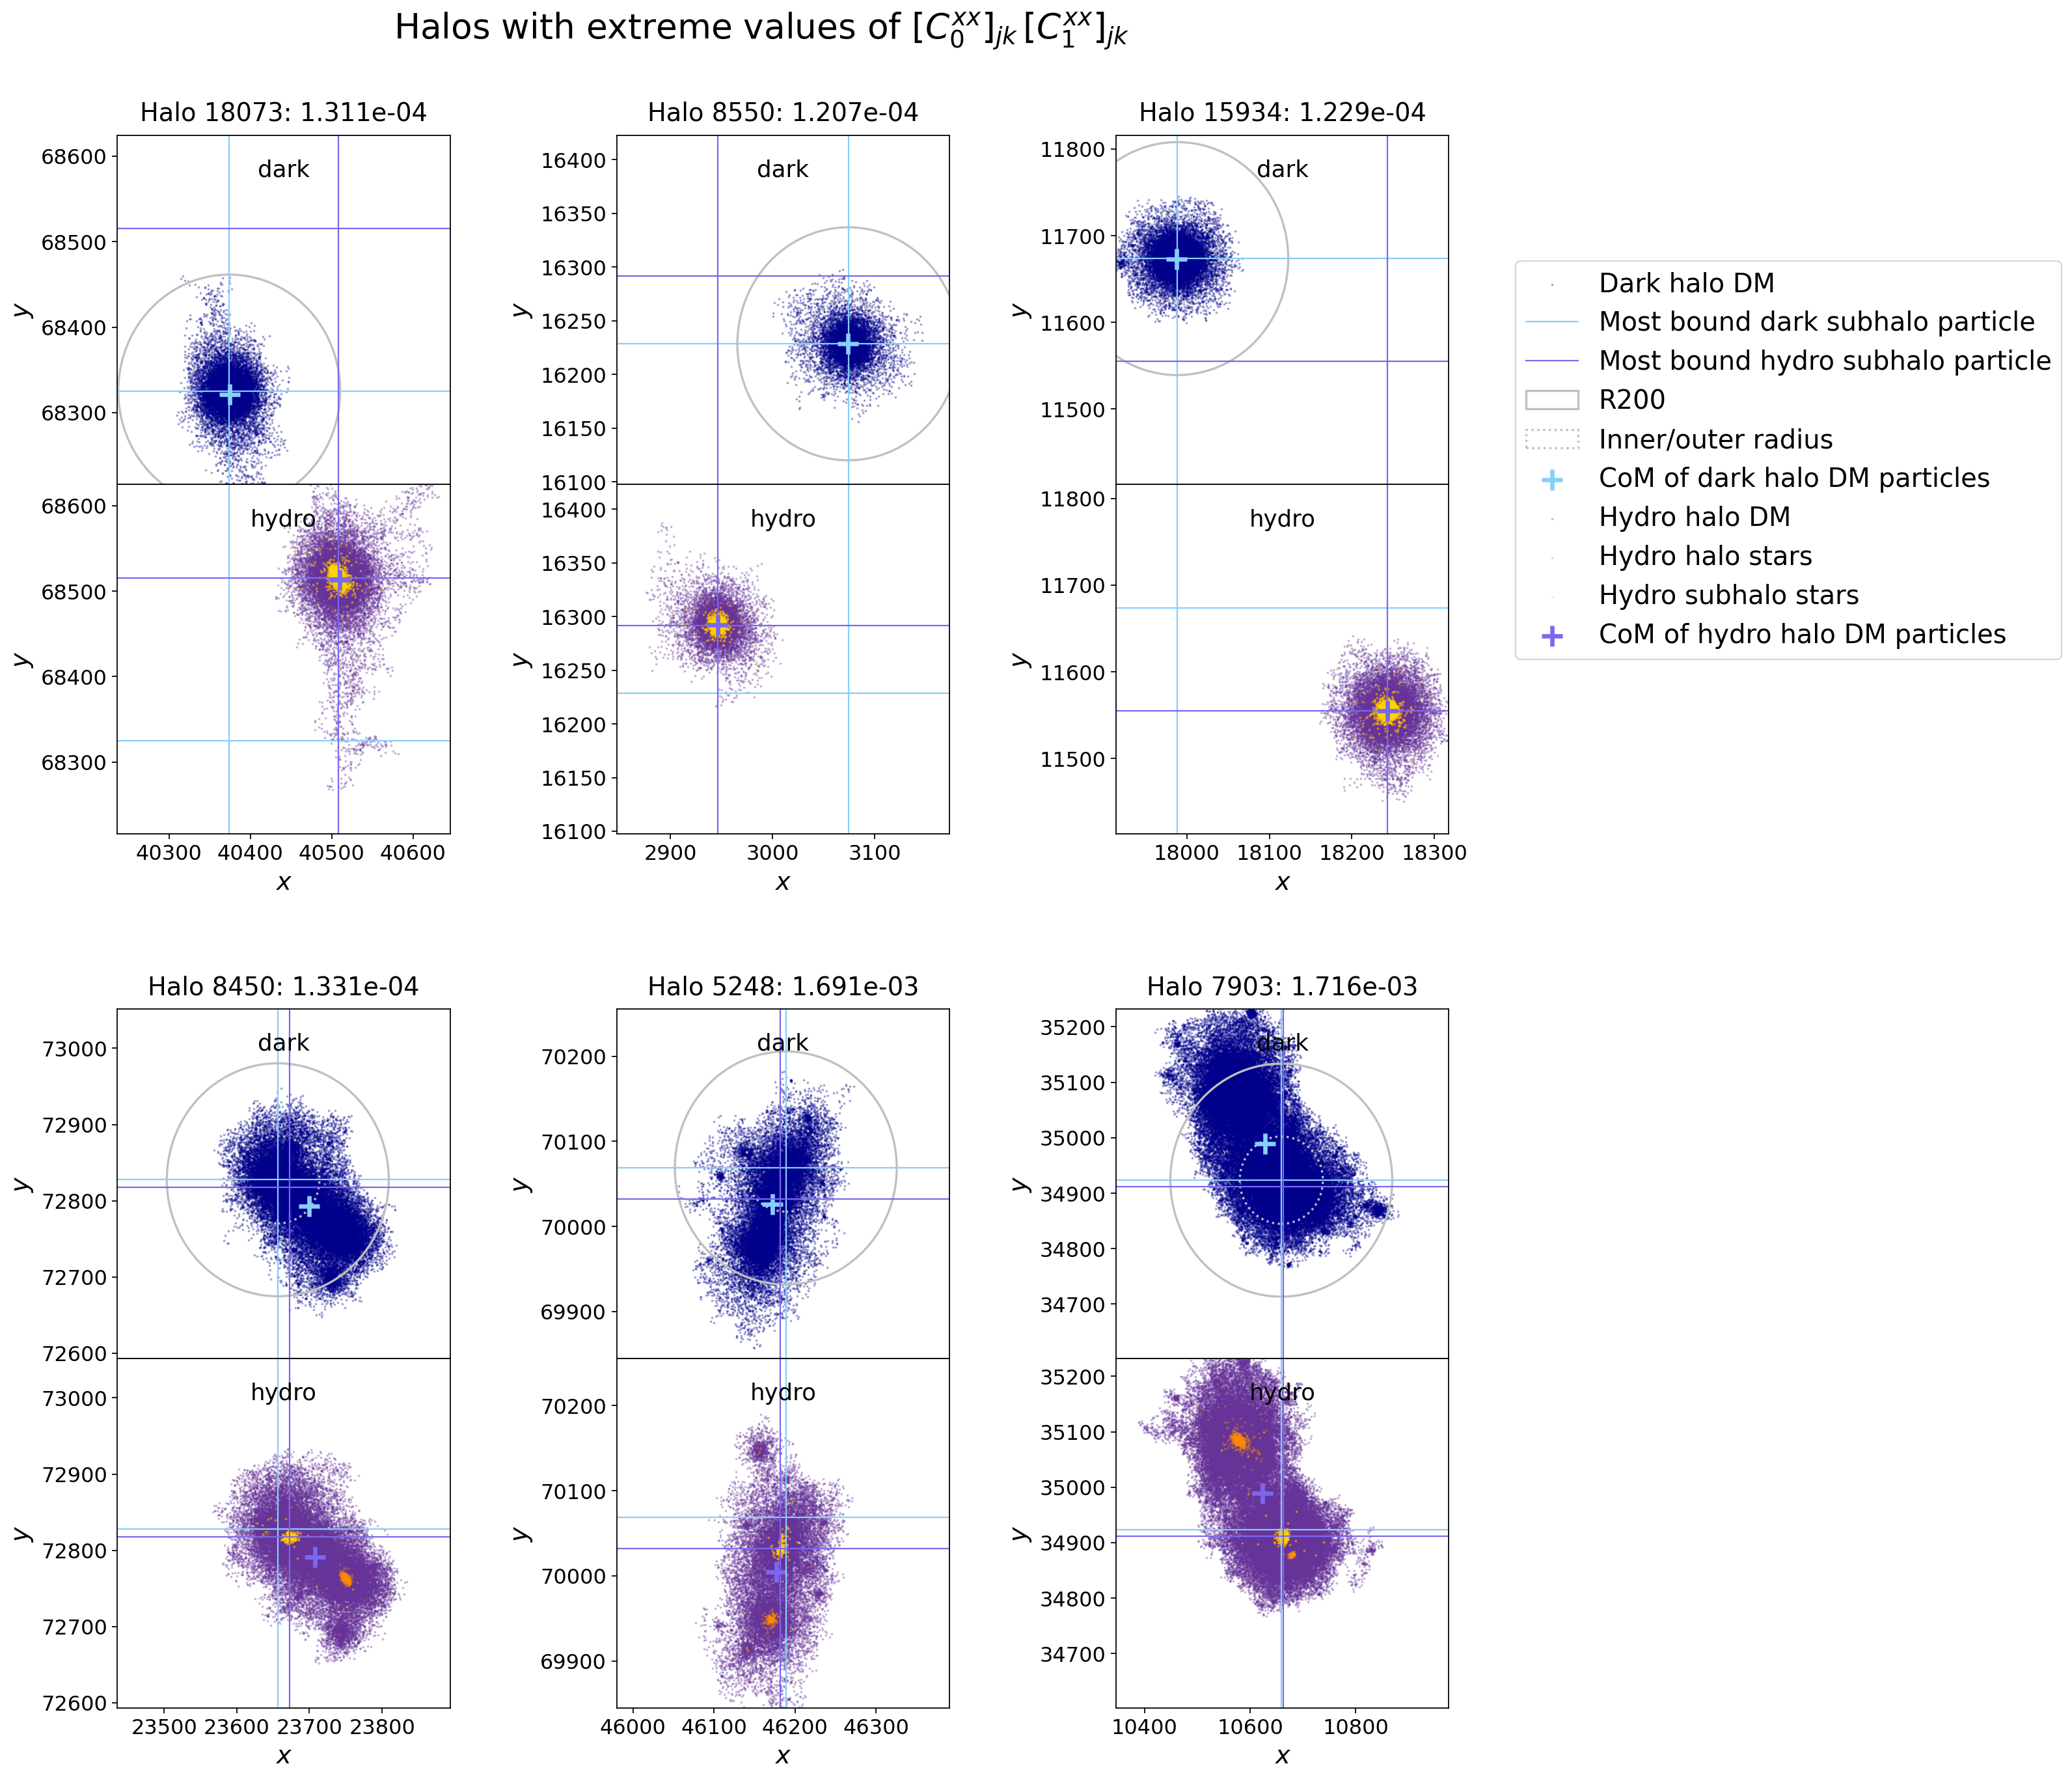

In [72]:
i_best = 0
idx_feat = idxs_ordered_best[i_best]
name_feat = 'Halos with extreme values of '+scalar_name(feature_arr_all[0][idx_feat], geo_feature_arr_pseudo)
n_each = int(n_plot/2)
# BUG HERE - corrupted h5 file, so instead im just skipping the first (lowest) one
idxs_halos_low = np.argpartition(features_all[:,idx_feat], n_each)[:n_each+1]
idxs_halos_high = np.argpartition(features_all[:,idx_feat], -n_each)[-n_each:]
idxs_halos = np.concatenate((idxs_halos_low, idxs_halos_high))
halos = sim_reader.dark_halo_arr[idxs_halos][1:]
titles = [f'Halo {idx_halo}: {features_all[idx_halo, idx_feat]:.3e}' for idx_halo in idxs_halos]
plotter.plot_halos_dark_and_hydro(halos, sim_reader.base_path_dark, sim_reader.base_path_hydro, sim_reader.snap_num,
                             nrows, ncols, titles, title=name_feat)

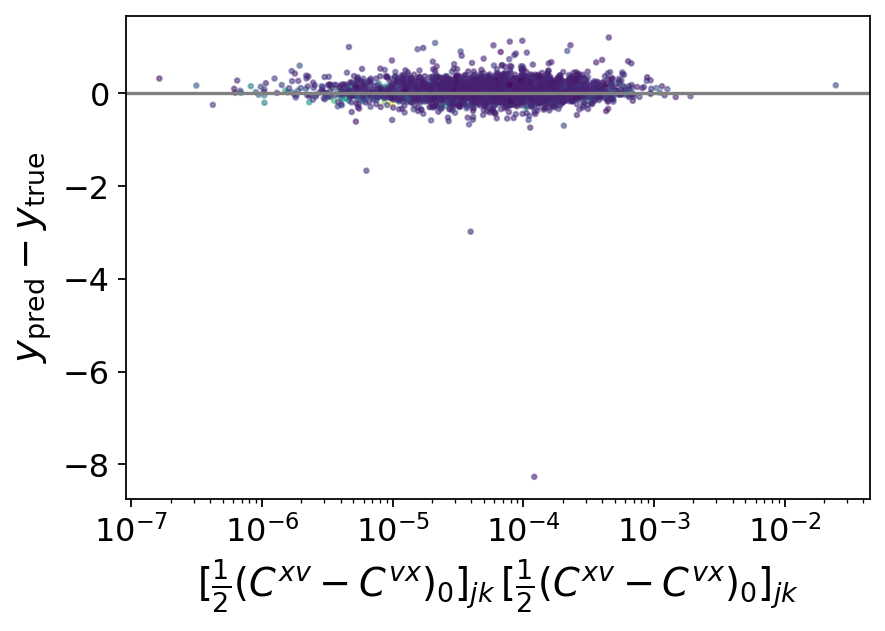

In [38]:
i_best = 1
idx_feat = idxs_ordered_best[i_best]
y_pred = fitter.y_scalar_pred
y_true = fitter.y_scalar_test
diffs = y_pred - y_true
plt.scatter(features_all[idx_test,idx_feat], diffs, c=log_m_200m[idx_test], s=4, alpha=0.5)
plt.axhline(0, color='grey')
plt.xlabel(rf'{scalar_name(feature_arr_all[0][idx_feat], geo_feature_arr_pseudo)}')
plt.ylabel(r'$y_\mathrm{pred} - y_\mathrm{true}$')

plt.xscale('log')

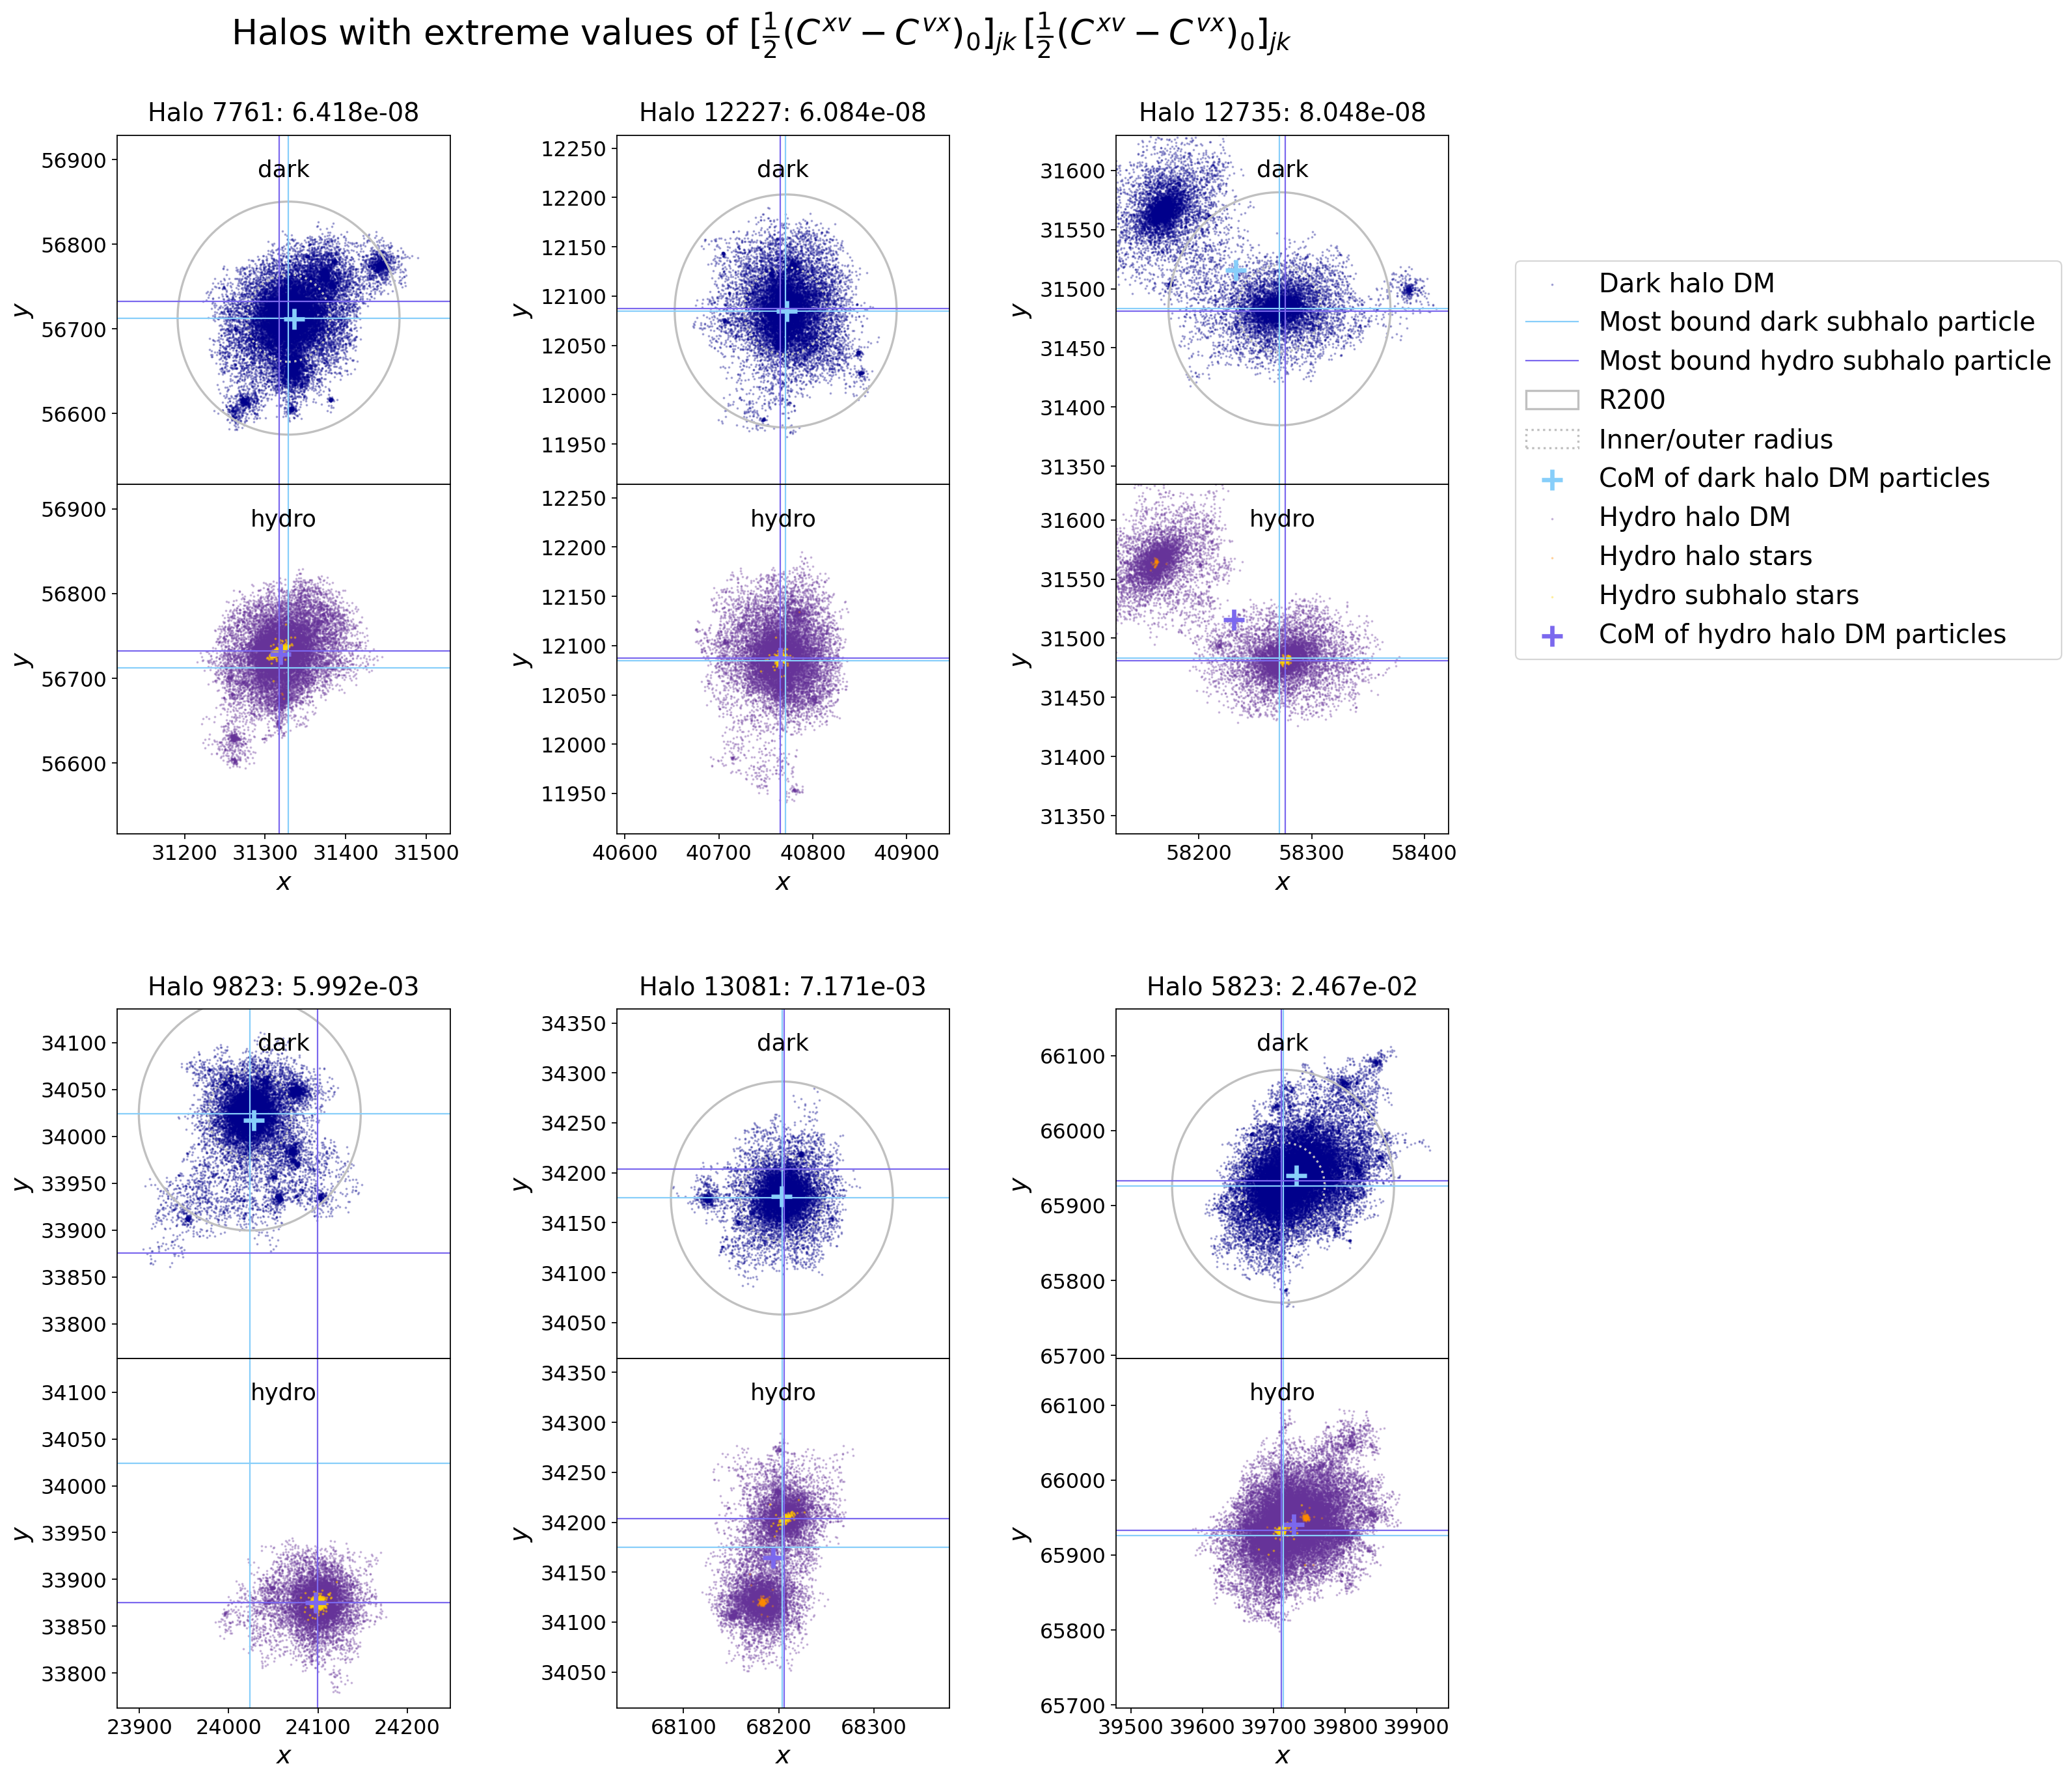

In [73]:
i_best = 1
idx_feat = idxs_ordered_best[i_best]
name_feat = scalar_name(feature_arr_all[0][idx_feat], geo_feature_arr_pseudo)
title_feat = 'Halos with extreme values of '+name_feat
n_each = int(n_plot/2)
idxs_halos_low = np.argpartition(features_all[:,idx_feat], n_each)[:n_each]
idxs_halos_high = np.argpartition(features_all[:,idx_feat], -n_each)[-n_each:]
idxs_halos = np.concatenate((idxs_halos_low, idxs_halos_high))
halos = sim_reader.dark_halo_arr[idxs_halos]
titles = [f'Halo {idx_halo}: {features_all[idx_halo, idx_feat]:.3e}' for idx_halo in idxs_halos]
plotter.plot_halos_dark_and_hydro(halos, sim_reader.base_path_dark, sim_reader.base_path_hydro, sim_reader.snap_num,
                             nrows, ncols, titles, title=title_feat)

Text(0, 0.5, '$y_\\mathrm{pred} - y_\\mathrm{true}$')

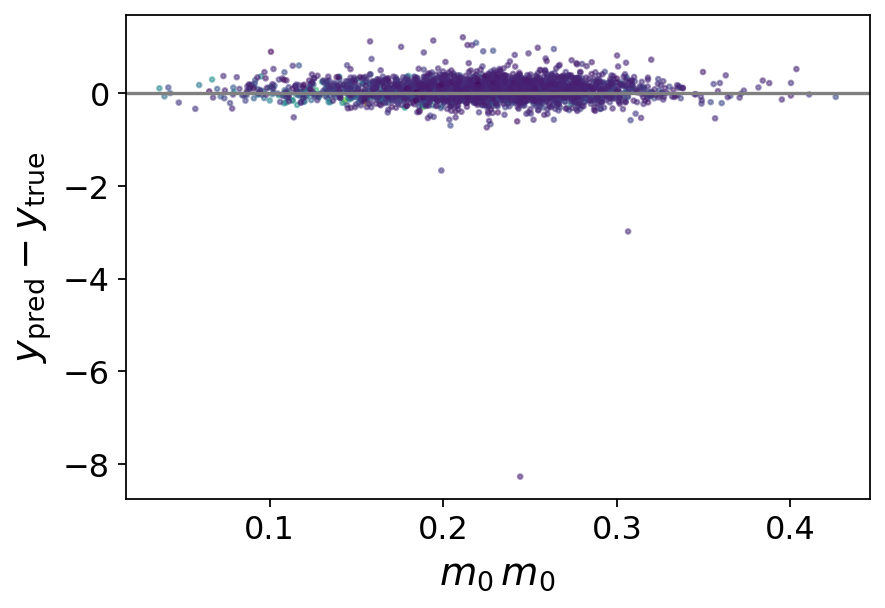

In [60]:
i_best = 2
idx_feat = idxs_ordered_best[i_best]
y_pred = fitter.y_scalar_pred
y_true = fitter.y_scalar_test
diffs = y_pred - y_true
plt.scatter(features_all[idx_test,idx_feat], diffs, c=log_m_200m[idx_test], s=4, alpha=0.5)
plt.axhline(0, color='grey')
plt.xlabel(rf'{scalar_name(feature_arr_all[0][idx_feat], geo_feature_arr_pseudo)}')
plt.ylabel(r'$y_\mathrm{pred} - y_\mathrm{true}$')

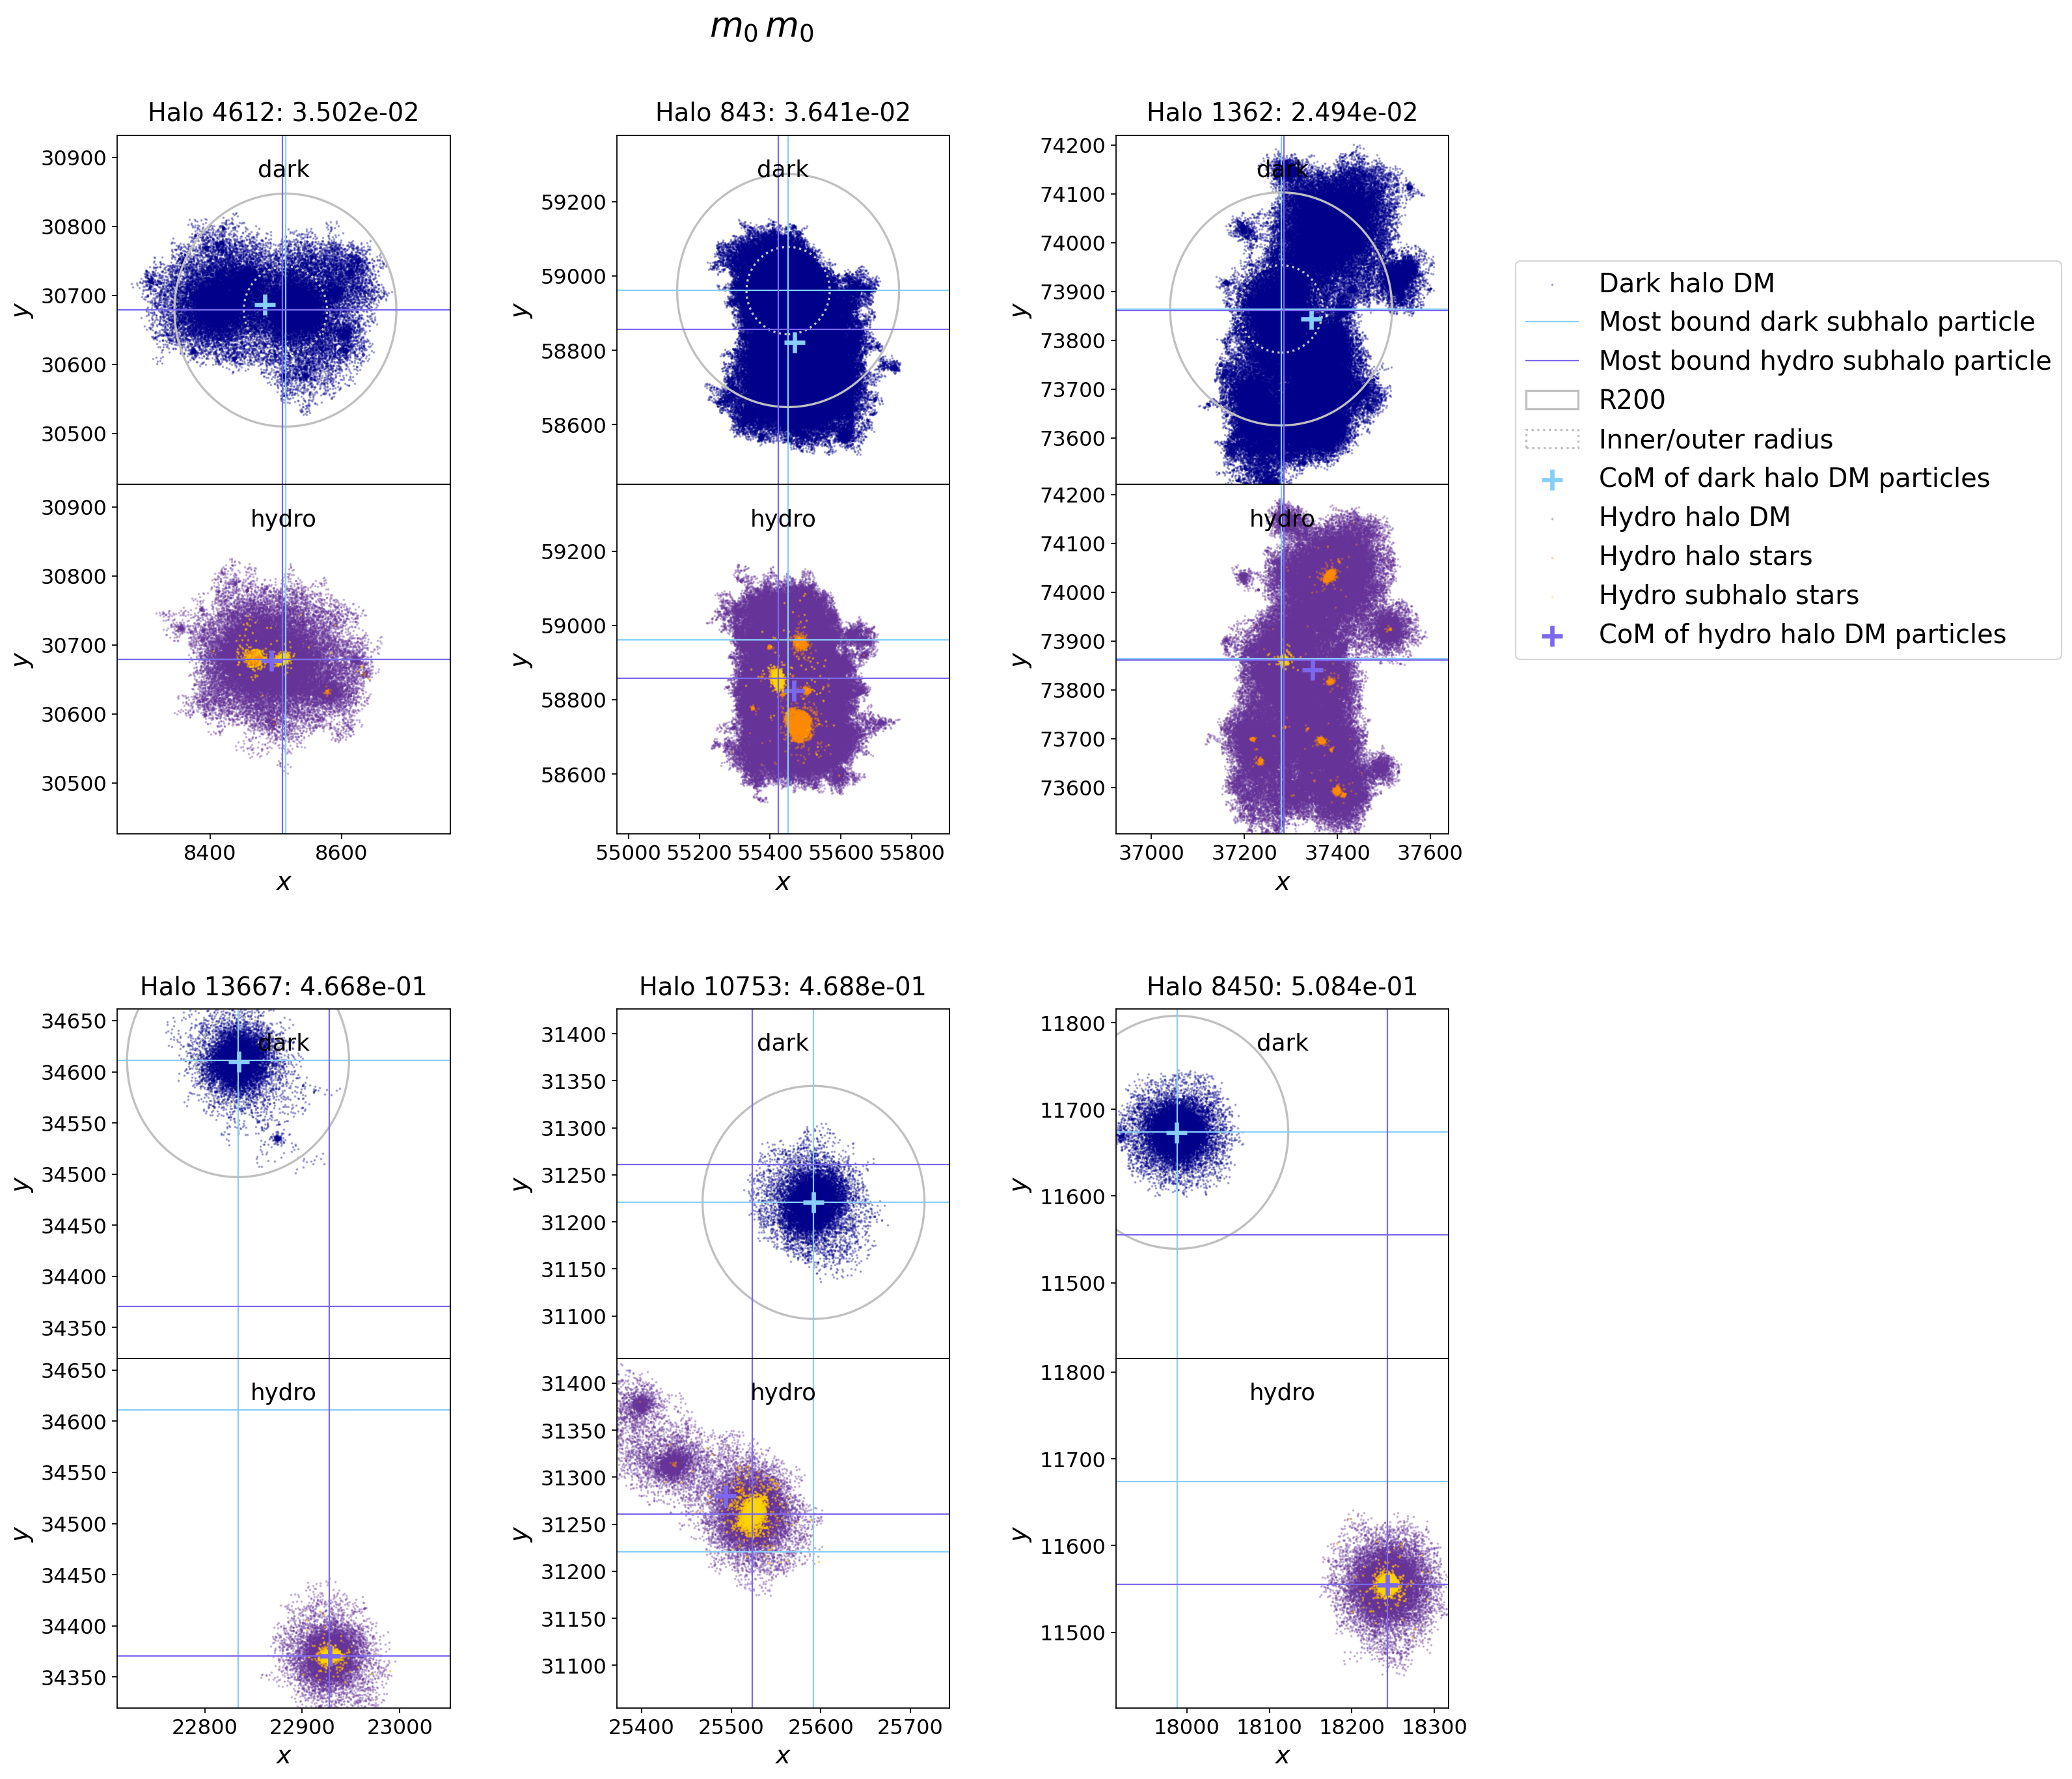

In [74]:
i_best = 2
idx_feat = idxs_ordered_best[i_best]
name_feat = scalar_name(feature_arr_all[0][idx_feat], geo_feature_arr_pseudo)
title_feat = 'Halos with extreme values of '+name_feat
n_each = int(n_plot/2)
idxs_halos_low = np.argpartition(features_all[:,idx_feat], n_each)[:n_each]
idxs_halos_high = np.argpartition(features_all[:,idx_feat], -n_each)[-n_each:]
idxs_halos = np.concatenate((idxs_halos_low, idxs_halos_high))
halos = sim_reader.dark_halo_arr[idxs_halos]
titles = [f'Halo {idx_halo}: {features_all[idx_halo, idx_feat]:.3e}' for idx_halo in idxs_halos]
plotter.plot_halos_dark_and_hydro(halos, sim_reader.base_path_dark, sim_reader.base_path_hydro, sim_reader.snap_num,
                             nrows, ncols, titles, title=name_feat)

# Feature imp

In [76]:
N_feat = features_all.shape[1]
idxs_feats_remaining = np.array(list(range(N_feat)))

groups = []
idxs_ordered_best = []
errors_best = []
chi2s_best = []

errors = np.full(N_feat, np.inf)
chi2s = np.full(N_feat, np.inf)
  
for idx in idxs_feats_remaining:

    idxs_to_use = np.append(np.array(idxs_ordered_best, dtype=int), idx)
    features = features_all[:,idxs_to_use]

    fitter = LinearFitter(features, log_m_stellar, 
                        y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                        x_features_extra=x_features_extra)
    fitter.split_train_test(idx_train, idx_val)
    fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
    fitter.predict_test()

    error, n_outliers = utils.compute_error(fitter, test_error_type='percentile')
    errors[idx] = error
    chi2s[idx] = fitter.chi2

In [98]:
n_lowest = 2
idxs_lowest_err = np.argpartition(errors, n_lowest)[:n_lowest]
err_firstplat = np.max(errors[idxs_lowest_err])

idx_min = idxs_lowest_err[np.argmin(errors[idxs_lowest_err])]

print("Min:")
display(Markdown(scalar_name(feature_arr_all[0][idx_min], geo_feature_arr_pseudo)))
    
print("First plateau:")
idxs_plat = np.where(errors==err_firstplat)[0]
for idx in idxs_plat:
    display(Markdown(scalar_name(feature_arr_all[0][idx], geo_feature_arr_pseudo)))
    

Min:


$[C^{xx}_0]_{jk} \, [C^{xx}_1]_{jk}$

First plateau:


$m_0 \, m_0$

$m_0 \, \lambda_1(C^{vv}_0)$

$m_0 \, \lambda_2(C^{vv}_0)$

$m_0 \, \lambda_3(C^{vv}_0)$

$\lambda_2(C^{vv}_0) \, \lambda_2(C^{vv}_0)$

$\lambda_2(C^{vv}_0) \, \lambda_1(C^{vv}_0)$

$\lambda_1(C^{vv}_0) \, \lambda_1(C^{vv}_0)$

$\lambda_3(C^{vv}_0) \, \lambda_3(C^{vv}_0)$

$\lambda_3(C^{vv}_0) \, \lambda_2(C^{vv}_0)$

$\lambda_3(C^{vv}_0) \, \lambda_1(C^{vv}_0)$

$m_0 \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$m_0 \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$m_0 \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_1(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_1(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_1(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_2(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_3(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_3(C^{vv}_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_2(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_2(C^{vv}_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_3(C^{vv}_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$m_0 \, \lambda_3(C^{xx}_0)$

$m_0 \, \lambda_2(C^{xx}_0)$

$m_0 \, \lambda_1(C^{xx}_0)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_1(C^{vv}_0) \, \lambda_2(C^{xx}_0)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_1(C^{vv}_0) \, \lambda_1(C^{xx}_0)$

$\lambda_2(C^{vv}_0) \, \lambda_1(C^{xx}_0)$

$\lambda_2(C^{vv}_0) \, \lambda_2(C^{xx}_0)$

$\lambda_2(C^{vv}_0) \, \lambda_3(C^{xx}_0)$

$\lambda_3(C^{vv}_0) \, \lambda_1(C^{xx}_0)$

$\lambda_3(C^{vv}_0) \, \lambda_2(C^{xx}_0)$

$\lambda_3(C^{vv}_0) \, \lambda_3(C^{xx}_0)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0)$

$\lambda_1(C^{vv}_0) \, \lambda_3(C^{xx}_0)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_0)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_0)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_0)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_0)$

$\lambda_2(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_0)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_1(C^{xx}_0)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_2(C^{xx}_0)$

$\lambda_3(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_0)$

$\lambda_1(\frac{1}{2} (C^{xv} + C^{vx})_0) \, \lambda_3(C^{xx}_0)$

$\lambda_2(C^{xx}_0) \, \lambda_1(C^{xx}_0)$

$\lambda_3(C^{xx}_0) \, \lambda_3(C^{xx}_0)$

$\lambda_3(C^{xx}_0) \, \lambda_2(C^{xx}_0)$

$\lambda_1(C^{xx}_0) \, \lambda_1(C^{xx}_0)$

$\lambda_3(C^{xx}_0) \, \lambda_1(C^{xx}_0)$

$\lambda_2(C^{xx}_0) \, \lambda_2(C^{xx}_0)$

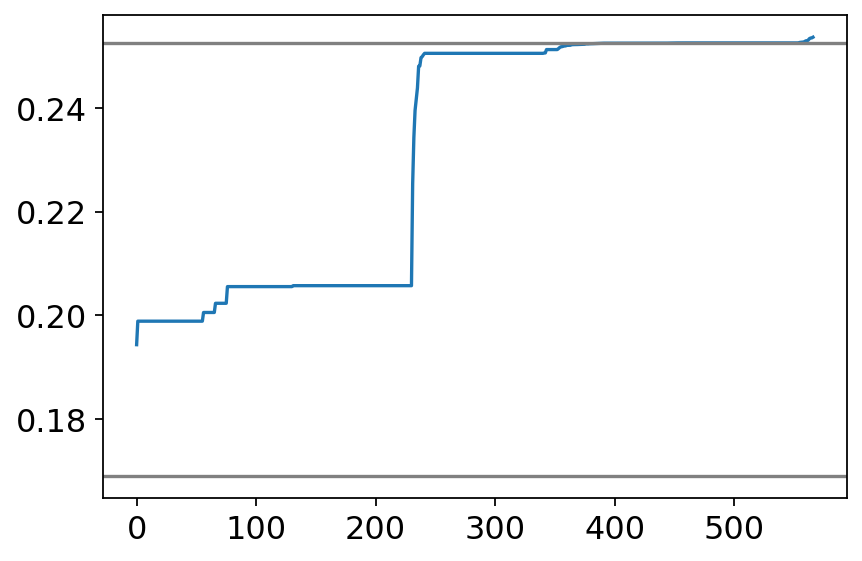

In [82]:
plt.plot(sorted(errors))
plt.axhline(error_powerlawMRV, color='grey')
plt.axhline(error_all, color='grey', label='fit with all features')


# Fitting other properties

In [ ]:
sim_reader.add_catalog_property_to_halos('radius_hydro_subhalo_star')
radius_stellar = np.array([dark_halo.catalog_properties['radius_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])
log_radius_stellar = np.log10(radius_stellar)

sim_reader.add_catalog_property_to_halos('sfr_hydro_subhalo_star')
sfr = np.array([dark_halo.catalog_properties['sfr_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])
log_sfr = np.log10(sfr)

In [ ]:
ones = np.ones(len(radius_stellar))

In [ ]:
y_label=r'log($R_\mathrm{stellar}$ [ckpc/h])'
print(np.min(radius_stellar), np.max(radius_stellar))
bins = np.linspace(-1, 2)
_ = plt.hist(log_radius_stellar, bins=bins)
plt.xlabel(y_label)
plt.ylabel('count')

In [ ]:
idx_nonzero = np.where(log_radius_stellar > 0)[0]

frac_train, frac_test = 0.70, 0.15
random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr[idx_nonzero]])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, frac_test=frac_test)

In [ ]:
fitter = LinearFitter(scalar_featurizer.scalar_features[idx_nonzero], log_radius_stellar[idx_nonzero], 
                    ones[idx_nonzero], uncertainties=None,
                    x_features_extra=x_features_extra[idx_nonzero])
fitter.split_train_test(idx_train, idx_test)
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
lim = (-1,2)
plotter.plot_fits(fitter, log_radius_stellar[idx_nonzero], y_lim=lim, y_label=y_label)

In [ ]:
print(np.min(log_radius_stellar[idx_nonzero]), np.max(log_radius_stellar[idx_nonzero]))
print(np.min(fitter.y_scalar_test), np.max(fitter.y_scalar_test))
print(np.min(fitter.y_scalar_test_scaled), np.max(fitter.y_scalar_test_scaled))
print(np.min(fitter.y_scalar), np.max(fitter.y_scalar))

In [ ]:
idx_nonzero = np.where(log_sfr > 0)[0]

frac_train, frac_test = 0.70, 0.15
random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr[idx_nonzero]])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, frac_test=frac_test)

In [ ]:
y_label=r'log(SFR $[M_\odot/yr]$)'
print(np.min(sfr), np.max(sfr))
bins = np.linspace(-4, 2)
_ = plt.hist(log_sfr, bins=bins)
plt.xlabel(y_label)
plt.ylabel('count')

In [ ]:
fitter = LinearFitter(scalar_featurizer.scalar_features[idx_nonzero], log_sfr[idx_nonzero], 
                    ones[idx_nonzero], uncertainties=None,
                    x_features_extra=x_features_extra[idx_nonzero])
fitter.split_train_test(idx_train, idx_test)
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
lim = (-4, 2)
plotter.plot_fits(fitter, log_sfr[idx_nonzero], y_lim=lim, y_label=y_label)

In [ ]:
print(np.min(log_sfr[idx_nonzero]), np.max(log_sfr[idx_nonzero]))
print(np.min(fitter.y_scalar_test), np.max(fitter.y_scalar_test))
print(np.min(fitter.y_scalar_test_scaled), np.max(fitter.y_scalar_test_scaled))
print(np.min(fitter.y_scalar), np.max(fitter.y_scalar))